# 1. Sequence Retrieval, Consensus Tree and newick-iTOL visualisation Using QIIME2 and DADA 
Assessing the Role of Microbial Genera in Corrosion Failure of Water and Cooling Systems

## 1.1. Introduction 
This notebook follows the next steps of the previous notebook 4. The main objective is to sequence, make a newick tree hierarchical tree for each of the tree base dataframes 
Core taxa tree (~60 highest abundance bacteria)  
Usual suspects tree (known corrosion-causing bacteria)   
Checked genera tree (statistically significant bacteria)  
Then making the sequence of the merged three dataframes core_check_usual_taxa.  
This notebook builds upon findings from notebook 4, focusing on the phylogenetic analysis of bacterial genera associated with corrosion in water and cooling systems. Through the systematic retrieval and analysis of 16S rRNA sequences from the NCBI GenBank database, we aim to construct phylogenetic trees for three distinct bacterial groups: the core taxa representing the 60 most abundant bacteria, the usual suspects comprising known corrosion-causing bacteria, and the checked genera identified through statistical significance.
The analysis begins with individual tree construction for each group, followed by the creation of a merged phylogenetic tree incorporating all three datasets. This approach serves multiple purposes: it validates our statistical findings against known corrosion-causers, reveals evolutionary relationships that might explain shared mechanisms, and provides context for newly identified bacteria. By implementing UPGMA methodology and bootstrap analysis, we ensure robust tree construction and reliability assessment.
Our workflow encompasses sequence retrieval from NCBI, data validation, sequence alignment, and consensus tree construction. The resulting phylogenetic relationships will illuminate community power dynamics and bacterial assembly patterns, establishing a foundation for subsequent metabolic pathway analysis through PICRUSt. This understanding is crucial for the final machine learning ensemble, where we will integrate these findings with physicochemical data from Repository 1_Physicochemical.
The notebook employs various safety measures and optimization techniques, including controlled server interaction and comprehensive error handling, ensuring reliable data collection and analysis. Through this systematic approach, we aim to deepen our understanding of microbially influenced   corrosion while establishing a robust framework for future analyses.
  
MIC/  
├── 2_Micro/  
    ├── data_qiime/          # QIIME2 analysis results  
    │   ├── sequences/       # Raw and processed sequences  
    │   ├── quality/         # Quality analysis results  
    │   └── trees/          # Phylogenetic trees  
    └── notebooks/  
        └── sequences_qiime.ipynb  
        

I am having problems installilng packages from the terminal, so I am installing the biophyton from here.

## 1.2 Preprocessing the data 
This notebook has been worked in colab and in vsc, the code is silence eitherway.
### Mounting the data in colab

In [426]:
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC')'''

'''%pip install dendropy
%pip install --upgrade pip
# for colab and in the terminal 
#!pip install biopython'''
'''
from Bio import Phylo
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))  # Adjust size as needed
Phylo.draw(consensus_tree)
plt.show()
'''

'\nfrom Bio import Phylo\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(15, 10))  # Adjust size as needed\nPhylo.draw(consensus_tree)\nplt.show()\n'

In [427]:
'''# for cleaning in terminal
qiime tools clean-cache'''

'# for cleaning in terminal\nqiime tools clean-cache'

### 1.3. Importing the necesary libraries

In [428]:
# Standard library imports
import os
import json
import tempfile
import time
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Generator
from dataclasses import dataclass
from math import log
from random import choice
from datetime import datetime
import shutil
import logging

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Biopython imports
from Bio import Entrez, SeqIO, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.Consensus import majority_consensus

# QIIME2 imports
import qiime2
from qiime2.plugins import demux, dada2, phylogeny, alignment, diversity
from qiime2.plugins.feature_table.methods import rarefy

# Tree visualization imports
from ete3 import (
    Tree as EteTree,  # Renamed to avoid conflict
    TreeStyle, 
    NodeStyle, 
    TextFace, 
    RectFace, 
    faces, 
    CircleFace
)
import dendropy
from dendropy import Tree as DendroTree  # Renamed to avoid conflict

# Subprocess for external commands
import subprocess

# 1.4. Folder Creation for the Results: Data_tree
dedicated folder to keep the results and bootstraping of the present notebook  

In [429]:
# For VSCode
output_dir = Path("/home/beatriz/MIC/2_Micro/data_qiime")
# Create output directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)
bootstrap_dir = output_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)

input_dir = Path("/home/beatriz/MIC/2_Micro/data_tree")
original_sequences_file = input_dir / "final_sequences_integrate.fasta"

# For Colab
'''
from google.colab import drive
drive.mount('/content/drive')
base_dir = Path('/content/drive/My Drive/MIC/data')
bootstrap_dir = base_dir / "bootstrapping"
bootstrap_dir.mkdir(exist_ok=True)
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nbase_dir = Path(\'/content/drive/My Drive/MIC/data\')\nbootstrap_dir = base_dir / "bootstrapping"\nbootstrap_dir.mkdir(exist_ok=True)\n'

## 1.5. Loadging, cleaning and preparing the dataframe
This notebook is made specially to run one individual dataframe coming from : core_taxa and checked_genera come from book 3 directory /data. Usual genera was built on notebook 3 but has been re-think on notebook 4. The merged dataframe core_check_usual_taxa was built from the merge of all three trees and was built also on notebook 4. 
For simplicity the notebook is aim to run only one of this individual files only to change the origin import in excel and the color scheme in the iTOL section, which is done by silence and select the source_type in the next cell. 

In [430]:
#loading only one of each of the three dataframes for every complete run of the notebook
#source_type = 'checked'  # genera come from book 3 directly directory /data
#source_type = 'usual' #  re-made come from book 4 directory /data_ref
#source_type = 'core'   # genera come from book 3 directly directory /data
source_type = 'check_core_usual' # made on book 4 directory /data_ref

In [431]:
#selected = pd.read_excel("data/finalist_dfs.xlsx", sheet_name='core_taxa', header=[0,1,2,3,4,5,6,7])
selected = pd.read_excel('~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx', sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7])
# Drop first row (index 0) and first column in one chain
selected = selected.drop(index=0).drop(selected.columns[0], axis=1)
# Remove 'Unnamed' level names
selected.columns = selected.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# If the dataframe has Nan in sites it will replace it with Source
selected['Sites'] = selected['Sites'].fillna('Source')
# Fill the other index with nothing
selected = selected.fillna(' ')
# Setting index to Sites
selected= selected.set_index("Sites")
selected_taxa = selected.T

In [432]:
selected.head()

Category Rhodocyclales_Rhodocyclaceae_Azospira  \
                                             Bacteria   
                                       Proteobacteria   
                                   Betaproteobacteria   
                                        Rhodocyclales   
                                       Rhodocyclaceae   
                                             Azospira   
                                                  110   
Sites                                                   
site_1      3.0                             26.928048   
site_2      1.0                               1.85923   
site_3      1.0                              3.093543   
site_4      1.0                              2.573991   
site_5      1.0                              2.709369   

       Actinomycetales_Dermabacteraceae_Brachybacterium  \
                                               Bacteria   
                                         Actinobacteria   
                                         Actinobacteria   
                                        Actinomycetales   
                                       Dermabacteraceae   
                                        Brachybacterium   
                                                    140   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Actinomycetales_Brevibacteriaceae_Brevibacterium  \
                                               Bacteria   
                                         Actinobacteria   
                                         Actinobacteria   
                                        Actinomycetales   
                                      Brevibacteriaceae   
                                         Brevibacterium   
                                                    145   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Erysipelotrichales_Erysipelotrichaceae_Bulleidia  \
                                               Bacteria   
                                             Firmicutes   
                                        Erysipelotrichi   
                                     Erysipelotrichales   
                                    Erysipelotrichaceae   
                                              Bulleidia   
                                                    154   
Sites                                                     
site_1                                                0   
site_2                                                0   
site_3                                                0   
site_4                                                0   
site_5                                                0   

       Clostridiales_Clostridiaceae_Clostridium  \
                                       Bacteria   
                                     Firmicutes   
                                     Clostridia   
                                  Clostridiales   
                                 Clostridiaceae   
                                    Clostridium   
                                            214   
Sites                                             
site_1                                        0   
site_2                                        0   
site_3                                        0   
site_4                                        0   
site_5                                        0   

       Actin

In [433]:
selected_taxa["Source"].unique()

array([' ', 'chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us', 'core',
       'us'], dtype=object)

# 2. Sequences Retrieval
## 2.1 NBCI communication setup

In [434]:
'''# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL
Entrez.email = NCBI_EMAIL
Entrez.api_key = NCBI_API_KEY'''

'# Comunicating with the NCBI\nfrom config import NCBI_API_KEY, NCBI_EMAIL\nEntrez.email = NCBI_EMAIL\nEntrez.api_key = NCBI_API_KEY'

In [435]:
'''def setup_logging():
    """Configure logging to both file and console"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('sequence_retrieval.log'),
            logging.StreamHandler()
        ]
    )'''

'def setup_logging():\n    """Configure logging to both file and console"""\n    logging.basicConfig(\n        level=logging.INFO,\n        format=\'%(asctime)s - %(levelname)s - %(message)s\',\n        handlers=[\n            logging.FileHandler(\'sequence_retrieval.log\'),\n            logging.StreamHandler()\n        ]\n    )'

## 2.2. Sequence Collection

In [436]:
# Extract Genera from the multi-index and filter out empty strings
genera = [genus for genus in selected.columns.get_level_values(6).to_list() if genus.strip()]

## 2.3. Retriving Data from the NCBI
Following code is silent, so that I dont run it again by mistake and ask again the accession numbers to the NCBI

In [437]:
'''# Dictionary to store the results
results = {}
def search_sequences(
    genus: str,
    entrez: object,
    max_retries: int = 5,
    base_delay: int = 30,
    max_delay: int = 120
) -> Optional[List[str]]:
    """
    Search for sequences with improved error handling and validation.
    
    Args:
        genus: The genus name to search for
        entrez: Entrez object with configured email and API key
        max_retries: Maximum number of retry attempts
        base_delay: Initial delay between retries in seconds
        max_delay: Maximum delay between retries in seconds
    
    Returns:
        List of sequence IDs or None if unsuccessful
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND " "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                "16S rRNA[All Fields]) AND " "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
                # Add extra delay after successful read
                time.sleep(5)

            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error for {genus}: {str(ve)}")
                retry_count += 1
                continue
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
                        
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            return[]
            
        except entrez.HTTPError as he:
            logging.error(f"NCBI HTTP error: {str(he)}")
        except entrez.URLError as ue:
            logging.error(f"NCBI connection error: {str(ue)}")
        except Exception as e:
            logging.error(f"Unexpected error: {str(e)}")

        retry_count += 1
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** retry_count), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)

            if retry_count >=max_retries:
                logging.error(f"Max retries ({max_retries}) reached for {genus}")
                return None
        return []
# Save progress after each genus
def retrieve_sequences(
    genera: List[str],
    entrez: object,
    output_file: str = "sequence_results.txt",
    progress_file: str = "retrieval_progress.json"
) -> Dict[str, List[str]]:
    """
    Retrieve sequences with comprehensive logging, error handling with progress saving
    
    Args:
        genera: List of genus names
        entrez: Configured Entrez object
        output_file: Path to save detailed results
    
    Returns:
        Dictionary mapping genera to their sequence IDs
    """
    setup_logging()
    logging.info(f"Starting sequence retrieval for {len(genera)} genera")
    
    # Load any existing progress
    results = {}
    if os.path.exists(progress_file):
        try:
            with open(progress_file, 'r') as f:
                content = f.read()
                if content.strip():  # Check if file is not empty
                    results = json.loads(content)
                    logging.info(f"Loaded {len(results)} existing results")
                else:
                    logging.info("Progress file exists but is empty")
        except json.JSONDecodeError:
            logging.warning("Could not decode progress file, starting fresh")
    
    missing_genera = []
    start_time = datetime.now()
    
    total_genera = len(genera)
    processed_count = len(results)

    for genus in genera:
        # Skip if already processed
        if genus in results:
            logging.info(f"Skipping {genus} - already processed")
            continue

        processed_count += 1
        logging.info(f"Processing {genus} ({processed_count}/{total_genera})")
        
        sequence_ids = search_sequences(genus, entrez)
        
        if sequence_ids:
            results[genus] = sequence_ids
            # Save progress after each successful retrieval
            with open(progress_file, 'w') as f:
                json.dump(results, f)
        else:
            missing_genera.append(genus)
        
        success_rate = (len(results) / processed_count) * 100
        logging.info(f"Current success rate: {success_rate:.1f}%")
        
        time.sleep(30)
    
    # Generate summary
    elapsed_time = datetime.now() - start_time
    summary = f"""
    Sequence Retrieval Summary
    -------------------------
    Total genera processed: {total_genera}
    Successful retrievals: {len(results)}
    Failed retrievals: {len(missing_genera)}
    Success rate: {(len(results)/total_genera)*100:.1f}%
    Total time elapsed: {elapsed_time}

    Successful Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}: {len(ids)} sequences" for genus, ids in results.items()) + f"""

    Missing Genera:
    {'-' * 20}
    """ + '\n'.join(f"- {genus}" for genus in missing_genera)
    
    # Save summary to file
    with open(output_file, 'w') as f:
        f.write(summary)
    
    return results'''

'# Dictionary to store the results\nresults = {}\ndef search_sequences(\n    genus: str,\n    entrez: object,\n    max_retries: int = 5,\n    base_delay: int = 30,\n    max_delay: int = 120\n) -> Optional[List[str]]:\n    """\n    Search for sequences with improved error handling and validation.\n    \n    Args:\n        genus: The genus name to search for\n        entrez: Entrez object with configured email and API key\n        max_retries: Maximum number of retry attempts\n        base_delay: Initial delay between retries in seconds\n        max_delay: Maximum delay between retries in seconds\n    \n    Returns:\n        List of sequence IDs or None if unsuccessful\n    """\n    if not isinstance(genus, str) or not genus.strip():\n        raise ValueError("Genus must be a non-empty string")\n    if not hasattr(entrez, \'email\') or not entrez.email:\n        raise RuntimeError("Entrez email configuration missing")\n    \n    retry_count = 0\n    delay = base_delay\n\n    while retry_

In [438]:
'''# Calling the function
results = retrieve_sequences(genera, Entrez)'''

'# Calling the function\nresults = retrieve_sequences(genera, Entrez)'

## 2.4 Sucess Rate Sequenced Genera

In [439]:
'''print(f"Initial number of genera: {len(genera)}")
print(f"Number of genera with sequences: {len(results)}")
print(f"Success rate: {(len(results)/len(genera)*100):.2f}%")

# Which genera got sequences:
print("\nGenera with sequences:")
for genus, seq_list in results.items():
    print(f"{genus}: {len(seq_list)} sequences")'''

'print(f"Initial number of genera: {len(genera)}")\nprint(f"Number of genera with sequences: {len(results)}")\nprint(f"Success rate: {(len(results)/len(genera)*100):.2f}%")\n\n# Which genera got sequences:\nprint("\nGenera with sequences:")\nfor genus, seq_list in results.items():\n    print(f"{genus}: {len(seq_list)} sequences")'

## 2.5. Resulting accension numbers

In [440]:
'''# Print the results
for genus, ids in results.items():
    print(f"{genus}: {ids}")'''

'# Print the results\nfor genus, ids in results.items():\n    print(f"{genus}: {ids}")'

In [441]:
'''# Create a DataFrame from the dictionary
df_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])
df_accension.head(31)'''

"# Create a DataFrame from the dictionary\ndf_accension = pd.DataFrame(list(results.items()), columns=['Genus', 'IDs'])\ndf_accension.head(31)"

## 2.7. Merging Taxa, Abundance and Accension Numbers on a dataframe

In [442]:
'''# Merge the two DataFrames on the 'Genus' column
taxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')
# Save the merged sequences to use making the dendrogram notebook
taxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)'''

"# Merge the two DataFrames on the 'Genus' column\ntaxa_accension = pd.merge(selected_taxa, df_accension, on='Genus')\n# Save the merged sequences to use making the dendrogram notebook\ntaxa_accension.to_csv('data_tree/taxa_accension.csv', index=False)"

# 3. Retrieving Sequencies with the Accession Numbers
These numbers are the GenBank accession numbers, which are unique identifiers for sequences in the GenBank database. Following is to retrieve the actual sequences using these accession numbers.
## 3.1. Define get_sequence function: Final Sequences

In [443]:
'''# Specify email (required by NCBI)
Entrez.email = "wattsbeatrizamanda@gmail.com"

# Retrieve the sequence for a given accession number
def get_sequence(accession):
    try:
       handle = Entrez.efetch(db="nucleotide", 
                             id=accession, 
                             rettype="fasta",  # Keep FASTA format
                             retmode="text")
       record = SeqIO.read(handle, "fasta")
       handle.close()
        
       sequence = str(record.seq)
       if sequence and len(sequence) > 0:  # Check if sequence exists and is not empty
           print(f"Got sequence of length {len(sequence)} for {accession}")
           return sequence
       else:
           print(f"Warning: Empty sequence for {accession}")
           return None
        
    except Exception as e:
        print(f"Failed to get sequence for {accession}: {e}")
        return None'''

'# Specify email (required by NCBI)\nEntrez.email = "wattsbeatrizamanda@gmail.com"\n\n# Retrieve the sequence for a given accession number\ndef get_sequence(accession):\n    try:\n       handle = Entrez.efetch(db="nucleotide", \n                             id=accession, \n                             rettype="fasta",  # Keep FASTA format\n                             retmode="text")\n       record = SeqIO.read(handle, "fasta")\n       handle.close()\n        \n       sequence = str(record.seq)\n       if sequence and len(sequence) > 0:  # Check if sequence exists and is not empty\n           print(f"Got sequence of length {len(sequence)} for {accession}")\n           return sequence\n       else:\n           print(f"Warning: Empty sequence for {accession}")\n           return None\n        \n    except Exception as e:\n        print(f"Failed to get sequence for {accession}: {e}")\n        return None'

Make the df with the accension numbers with the actual number and not just the index, code difficult to run in this machine

## 3.2 Validation the Retrieved Sequences

In [444]:
'''def validate_sequence(sequence):
    """Basic sequence validation"""
    return len(sequence) >= 500  # check if sequence is long enough

results =[]
# Loop over the rows in the DataFrame
for i, row in taxa_accension.iterrows():
    # Get the genus, GID and accession numbers for the current row
    genus = row['Genus']
    gid = row['GID']
    
    # Convert string representation of list to actual list 
    accession_numbers = row['IDs']

    # Debug - print current genus being processed
    print(f"Processing {genus}")

    # Initialize a variable to store the accession number that returns a valid sequence
    valid_accession = None

    # Loop over the accession numbers
    for accession in accession_numbers:
        # Retrieve the sequence
        sequence = get_sequence(accession)

        # Debug print
        if sequence:
            print(f"Sequence length: {len(sequence)}")

        # Check if a sequence was found and is valid
        if sequence is not None and validate_sequence(sequence):
            # Store the accession number and sequence
            valid_accession = accession
            valid_sequence = sequence
            break
    
    # If we found a valid sequence, add it to results
    if valid_accession is not None:
        results.append({
            'Genus': genus,
            'GID': gid,
            'Accession': valid_accession,
            'Sequence': valid_sequence
        })

    # Pause for 5 second
    time.sleep(5)

# Convert the list of results to a DataFrame
final_sequences = pd.DataFrame(results)

# Print some information about the results
print(f"\nNumber of sequences retrieved: {len(final_sequences)}")
print("\nFirst few rows:")
print(final_sequences.head(5))'''

'def validate_sequence(sequence):\n    """Basic sequence validation"""\n    return len(sequence) >= 500  # check if sequence is long enough\n\nresults =[]\n# Loop over the rows in the DataFrame\nfor i, row in taxa_accension.iterrows():\n    # Get the genus, GID and accession numbers for the current row\n    genus = row[\'Genus\']\n    gid = row[\'GID\']\n    \n    # Convert string representation of list to actual list \n    accession_numbers = row[\'IDs\']\n\n    # Debug - print current genus being processed\n    print(f"Processing {genus}")\n\n    # Initialize a variable to store the accession number that returns a valid sequence\n    valid_accession = None\n\n    # Loop over the accession numbers\n    for accession in accession_numbers:\n        # Retrieve the sequence\n        sequence = get_sequence(accession)\n\n        # Debug print\n        if sequence:\n            print(f"Sequence length: {len(sequence)}")\n\n        # Check if a sequence was found and is valid\n        if seq

# 4. DADA2 Denoising
While DADA2 is typically used for amplicon data, can be adapted quality filtering

In [445]:
def filter_raw_sequences(sequences_file):
    """
    Basic DADA2-like quality assessment without removing sequences
    Returns list of sequences for writing to file
    """
    quality_stats = []
    sequences = []  # Store sequences in a list
    
    for record in SeqIO.parse(sequences_file, "fasta"):
        # Calculate quality metrics
        seq_length = len(record.seq)
        n_content = record.seq.count('N')/len(record.seq)
        
        quality_stats.append({
            'id': record.id,
            'length': seq_length,
            'N_content': f"{n_content:.2%}"
        })
        sequences.append(record)  # Keep all sequences
        
    # Print quality report
    print("\nSequence Quality Report:")
    for stat in quality_stats:
        print(f"- {stat['id']}: Length={stat['length']}bp, N content={stat['N_content']}")
        
    return sequences  # Return list of sequences

In [446]:
original_sequences_file = Path("/home/beatriz/MIC/2_Micro/data_tree/final_sequences_integrate.fasta")
filtered_seq = filter_raw_sequences(original_sequences_file)
output_file = Path("data_qiime/final_sequences_DADA.fasta")
SeqIO.write(filtered_seq, output_file, "fasta")
print(f"Original sequences: {sum(1 for _ in SeqIO.parse(original_sequences_file, 'fasta'))}")
print(f"Filtered sequences: {len(filtered_seq)}")


Sequence Quality Report:
- Azospira: Length=1057bp, N content=0.00%
- Brachybacterium: Length=1385bp, N content=0.00%
- Brevibacterium: Length=1366bp, N content=0.00%
- Bulleidia: Length=1617bp, N content=0.00%
- Clostridium: Length=601bp, N content=0.00%
- Corynebacterium: Length=542bp, N content=0.00%
- Enterococcus: Length=1464bp, N content=0.00%
- Gelria: Length=1710bp, N content=0.00%
- Halomonas: Length=1410bp, N content=0.00%
- Legionella: Length=560bp, N content=0.00%
- Mycobacterium: Length=535bp, N content=0.00%
- Mycoplana: Length=1270bp, N content=0.00%
- Neisseria: Length=1708bp, N content=0.00%
- Novosphingobium: Length=1410bp, N content=0.00%
- Oerskovia: Length=1321bp, N content=0.00%
- Opitutus: Length=1495bp, N content=0.00%
- Oxobacter: Length=575bp, N content=0.00%
- Paracoccus: Length=501bp, N content=0.00%
- Phenylobacterium: Length=1621bp, N content=0.00%
- Porphyrobacter: Length=810bp, N content=0.00%
- Prevotella: Length=840bp, N content=0.00%
- Pseudarthrobac

The quality report shows all sequences have good quality (0% N content) and varying lengths, which is good news!

# 4.2. Trimming Sequences
previous sequence quality report showed lengths ranging from ~500bp to ~1700bp, so the sequences will be trimmed at this stage on the pipleline before being aligned with MAFF, it could improve consistency. However too much trimming will lost infomation on sequence lenght for realibility on phylogenetic analysis and picrust predictions.Parameters are min_length=750: Ensures enough sequence for reliable phylogenetic signal
max_length=1500: Removes overly long sequences while preserving most complete 16S genes.

In [447]:
def trim_sequences(input_file, output_file, min_length=500, max_length=1700):
    """
    Trim sequences to consistent length while preserving key 16S regions
    """
    trimmed_records = []
    stats = {'original': 0, 'kept': 0, 'too_short': 0, 'trimmed': 0}
    
    for record in SeqIO.parse(input_file, "fasta"):
        stats['original'] += 1
        
        # Remove leading/trailing gaps
        seq_str = str(record.seq).strip('-')
        
        if len(seq_str) < min_length:
            stats['too_short'] += 1
            continue
            
        if len(seq_str) > max_length:
            seq_str = seq_str[:max_length]
            stats['trimmed'] += 1
            
        record.seq = Seq(seq_str)
        trimmed_records.append(record)
        stats['kept'] += 1
    
    # Write trimmed sequences
    SeqIO.write(trimmed_records, output_file, "fasta")
    
    # Report statistics
    print("\nTrimming Statistics:")
    print(f"Original sequences: {stats['original']}")
    print(f"Sequences kept: {stats['kept']}")
    print(f"Too short (<{min_length}bp): {stats['too_short']}")
    print(f"Trimmed to {max_length}bp: {stats['trimmed']}")
    
    return trimmed_records

In [448]:
output_file = Path("data_qiime/final_sequences_trimm.fasta")
original_sequences_file = Path("/home/beatriz/MIC/2_Micro/data_tree/final_sequences_integrate.fasta")
trimm_seq = trim_sequences(original_sequences_file, output_file, min_length=500, max_length=1700)

SeqIO.write(trimm_seq, output_file, "fasta")
print(f"Original sequences: {sum(1 for _ in SeqIO.parse(original_sequences_file, 'fasta'))}")
print(f"Filtered sequences: {len(trimm_seq)}")


Trimming Statistics:
Original sequences: 79
Sequences kept: 79
Too short (<500bp): 0
Trimmed to 1700bp: 6
Original sequences: 79
Filtered sequences: 79


Lost Sequences 0, no sequences are less than 500 bp Trimmed Sequences (6 sequences > 1700bp), which is 7.6% needed trimming. That ensures that core 16S regions are preserved. 

# 5. QIIME2 Import and MAFFT Alignment
Sequence data was imported into QIIME2 format, posterior MAFFT alignment was performed using alignment.methods.mafft(). Then the aligned sequences are exported to "data_qiime/qiime_aligned_sequences.fasta".

In [449]:
from qiime2.plugins import alignment as q2alignment
original_sequences_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/final_sequences_trimm.fasta")
# Import directly into QIIME2
sequences_artifact = qiime2.Artifact.import_data(
    'FeatureData[Sequence]', 
    str(original_sequences_file)  # Convert Path to string for QIIME2
)

# Perform MAFFT alignment
aligned_sequences = alignment.methods.mafft(
    sequences=sequences_artifact,
    n_threads='auto')

# Export aligned sequences as a single file in the directory
output_file = Path("data_qiime/qiime_aligned_sequences.fasta")
aligned_sequences.alignment.export_data(output_file)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread -1 /tmp/qiime2/beatriz/data/b00a4efa-ae43-4b9e-ad2b-09be05f7afd8/data/dna-sequences.fasta



OS = linux
The number of physical cores =  1
inputfile = orig
79 x 1700 - 501 d
nthread = 1
nthreadpair = 1
nthreadtb = 1
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 40 ambiguous characters.
    1 / 79 (thread    0)
done.

Constructing a UPGMA tree (efffree=0) ... 
   70 / 79
done.

Progressive alignment 1/2... 
STEP    38 / 78 (thread    0)
Reallocating..done. *alloclen = 4407
STEP    68 / 78 (thread    0)
Reallocating..done. *alloclen = 5887
STEP    78 / 78 (thread    0)
done.

Making a distance matrix from msa.. 
    0 / 79 (thread    0)
done.

Constructing a UPGMA tree (efffree=1) ... 
   70 / 79
done.

Progressive alignment 2/2... 
STEP    29 / 78 (thread    0)
Reallocating..done. *alloclen = 4407
STEP    75 / 78 (thread    0)
Reallocating..done. *alloclen = 5475
STEP    76 / 78 (thread    0)
Reallocating..done. *alloclen = 6725
STEP    78 / 78 (thread 

Alignment was suscessfull, the MAFFT output shows that the input length was 1942 bases, used 1 thread for processing. 

# 4.1. Analyze diagnostic regions and sequence identity
checking if the imput file comply with the requirements for picrust2 to run. First we make sure no to take away the identify of what makes a bacteria.

In [450]:
def analyze_sequence_identity(input_fasta):
    """
    Analyze diagnostic regions and sequence identity
    """
    sequences = {}
    current_header = ""
    
    print("Reading sequences...")
    with open(input_fasta) as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                current_header = line
                sequences[current_header] = []
            elif line:
                sequences[current_header].append(line)
    
    # Join sequences
    for header in sequences:
        sequences[header] = ''.join(sequences[header])
    
    # Analyze variable regions
    seq_length = len(next(iter(sequences.values())))
    window_size = 50
    variability = []
    
    print("\nAnalyzing sequence variability...")
    for i in range(0, seq_length - window_size):
        window_sequences = [seq[i:i+window_size] for seq in sequences.values()]
        # Calculate variability excluding gaps
        bases_at_position = [set(seq[j] for seq in window_sequences if seq[j] != '-') 
                           for j in range(window_size)]
        variability.append(sum(len(bases) for bases in bases_at_position) / window_size)
    
    # Find highly variable regions (potential diagnostic regions)
    diagnostic_regions = []
    current_region = []
    
    for i, var in enumerate(variability):
        if var > 2.0:  # High variability threshold
            current_region.append(i)
        elif current_region:
            if len(current_region) >= 20:  # Minimum region size
                diagnostic_regions.append((min(current_region), max(current_region)))
            current_region = []
    
    print("\nDiagnostic regions found:")
    for start, end in diagnostic_regions:
        print(f"Region {start}-{end} (length: {end-start+1})")
        
    print("\nSequence identity summary:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Diagnostic regions preserved: {len(diagnostic_regions)}")
    print(f"Average variability: {sum(variability)/len(variability):.2f}")

# Run the analysis
aligned_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta")
analyze_sequence_identity(aligned_file)

Reading sequences...

Analyzing sequence variability...

Diagnostic regions found:
Region 0-94 (length: 95)
Region 141-256 (length: 116)
Region 298-465 (length: 168)
Region 493-1551 (length: 1059)
Region 1599-1695 (length: 97)
Region 1720-1854 (length: 135)
Region 1897-2239 (length: 343)
Region 2267-2427 (length: 161)
Region 2465-2549 (length: 85)
Region 2574-2836 (length: 263)
Region 2839-3354 (length: 516)
Region 3369-3532 (length: 164)
Region 3587-3624 (length: 38)
Region 3665-3694 (length: 30)

Sequence identity summary:
Total sequences: 79
Diagnostic regions preserved: 14
Average variability: 2.90


Comparative Analysis of Diagnostic Regions
Muscle vs QIIME:

|Region| With Muscle | With QIIME| Difference |
| -- | -- | -- |--|
|1   |      249-572 (324bp)  |    0-117 (118bp)  |      Different positioning|
|2   |      934-1653 (720bp) |    144-185 (42bp)  |     Different positioning|
|3   |      2344-2846 (503bp) |   208-278 (71bp)  |     Different positioning|
|4   |      2878-3276 (399bp) |   298-665 (368bp) |     Similar size, different position|

*Sequence Coverage*:
For the first alignment, the regions span from position 2 to 3276, covering most of the original sequence length. The most variable regions are substantial in length (>100 bases) and we have good distribution of regions throughout the sequence.
*Quality Indicators*: Average variability of 2.93 indicates good sequence diversity. Having 11 diagnostic regions is excellent for species identification. The regions are well-distributed, not clustered.
For the second alignment with QIIME the improvement is remarkable from 720 bases to 1165 on the best region and throught the others, qhich is quite good. Based on this, the trimming strategy will focus on preserving these regions. Next function optimizes cleaning and trimmind around these diagnostic regions.

# 4.2. Abundance Dataframes by Group
First we do the groupying by source, which is the final column on the selected dataframe, namely 
'chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us', 'core', 'us'

In [451]:
def process_integrated_data(df):
    """
    Process the integrated DataFrame to create a new DataFrame with clear column names
    and preserve all values including source information.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with MultiIndex index and site columns
    
    Returns:
    pandas.DataFrame: Processed DataFrame with clear structure
    """
    
    # Extract genera and GIDs from the index MultiIndex
    genera = df.index.get_level_values(6)[1:]  # Skip first row
    gids = pd.to_numeric(df.index.get_level_values(7)[1:], errors='coerce')
    
    # Create a new DataFrame with the extracted information
    result_df = pd.DataFrame({
        'Genus': genera,
        'GID': gids
    })
    
    # Add the site values from the original DataFrame
    for col in df.columns:
        result_df[col] = df.iloc[1:][col].values
    
    # Clean up the DataFrame
    result_df['GID'] = pd.to_numeric(result_df['GID'], errors='coerce')
    result_df = result_df.dropna(subset=['GID'])
    result_df['GID'] = result_df['GID'].astype(int)
    
    return result_df

def get_taxa_groups(df):
    """
    Separate the processed DataFrame into different taxa groups based on Source column
    
    Parameters:
    df (pandas.DataFrame): Processed DataFrame from process_integrated_data()
    
    Returns:
    dict: Dictionary containing DataFrames for different taxa groups
    """
    # Split the data into groups based on 'Source' column patterns
    
    # Known corrosion bacteria (any pattern with 'us')
    known_bacteria = df[df['Source'].str.contains('us', case=False, na=False)]
    
    # Pure checked bacteria (only 'chk' without 'core' or 'us')
    pure_checked = df[
        df['Source'].str.contains('chk', case=False, na=False) & 
        ~df['Source'].str.contains('core|us', case=False, na=False)
    ]
    
    # Pure core bacteria (only 'core' without 'chk' or 'us')
    pure_core = df[
        df['Source'].str.contains('core', case=False, na=False) & 
        ~df['Source'].str.contains('chk|us', case=False, na=False)
    ]
    
    # Checked-core bacteria (contains both 'core' and 'chk' but no 'us')
    checked_core = df[
        df['Source'].str.contains('chk.*core|core.*chk', case=False, na=False) & 
        ~df['Source'].str.contains('us', case=False, na=False)
    ]

    # Create groups dictionary
    taxa_groups = {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }
    
    # Print summary statistics
    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")
    
    # Verify total matches expected
    total_classified = len(known_bacteria) + len(pure_checked) + len(pure_core) + len(checked_core)
    print(f"\nTotal classified taxa: {total_classified}")
    print(f"Total in dataset: {len(df)}")
    
    return taxa_groups

# Usage example:
Integrated = process_integrated_data(selected_taxa)

# Get the groups
taxa_groups = get_taxa_groups(Integrated)

# Access individual groups - 
known_bacteria = taxa_groups['known_bacteria']    
pure_core = taxa_groups['pure_core']             
pure_checked = taxa_groups['pure_checked']        
checked_core = taxa_groups['checked_core']        


Detailed Classification Results:
Known corrosion bacteria: 17
Pure checked bacteria: 19
Pure core bacteria: 45
Checked-core bacteria: 3

Total classified taxa: 84
Total in dataset: 84


# 4.3. Comparative Analysis of Diagnostic Regions

In [452]:
def integrate_abundance_and_sequences(sequence_fasta, abundance_df, output_file):
    """
    Integrate sequence quality metrics with abundance data
    
    Args:
        sequence_fasta: Path to FASTA file with sequences
        abundance_df: DataFrame with abundance data (Genus, GID, sites, Source)
        output_file: Path to save integrated analysis
    """
    # Read sequences and calculate quality metrics
    sequences = {}
    current_header = ""
    
    print("Reading sequences...")
    with open(sequence_fasta) as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                current_header = line.split()[0][1:]  # Get genus name without '>'
                sequences[current_header] = []
            elif line:
                sequences[current_header].append(line)
    
    # Calculate sequence metrics
    sequence_metrics = {}
    for genus, seq_lines in sequences.items():
        seq = ''.join(seq_lines)
        non_gaps = sum(1 for c in seq if c != '-')
        metrics = {
            'sequence_length': len(seq),
            'non_gap_bases': non_gaps,
            'quality_ratio': non_gaps / len(seq),
        }
        sequence_metrics[genus] = metrics
    
    # Create integrated DataFrame
    metrics_df = pd.DataFrame.from_dict(sequence_metrics, orient='index')
    
    # Merge with abundance data
    integrated_df = abundance_df.merge(
        metrics_df, 
        left_on='Genus', 
        right_index=True, 
        how='left'
    )
    
    # Group analysis by Source
    print("\nAnalyzing sequence quality by source group:")
    source_analysis = integrated_df.groupby('Source').agg({
        'quality_ratio': ['mean', 'min', 'max', 'count'],
        'Genus': 'count'
    }).round(3)
    
    print("\nSource group summary:")
    print(source_analysis)
    
    # Identify potential issues
    print("\nPotential quality issues by source:")
    for source in integrated_df['Source'].unique():
        group_df = integrated_df[integrated_df['Source'] == source]
        low_quality = group_df[group_df['quality_ratio'] < 0.25]
        if not low_quality.empty:
            print(f"\n{source}:")
            for _, row in low_quality.iterrows():
                print(f"  {row['Genus']}: {row['quality_ratio']:.2%}")
    
    # Save integrated analysis
    integrated_df.to_excel(output_file, index=False)
    print(f"\nIntegrated analysis saved to: {output_file}")
    
    return integrated_df

In [453]:
# Analyze each group separately
aligned_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta")

# For known bacteria
known_output = aligned_file.parent / "known_bacteria_quality.xlsx"
known_quality = integrate_abundance_and_sequences(str(aligned_file), known_bacteria,  known_output)

# For pure core
core_output = aligned_file.parent / "pure_core_quality.xlsx"
core_quality = integrate_abundance_and_sequences(str(aligned_file),  pure_core, core_output)
    
# For pure checked
checked_output = aligned_file.parent / "pure_checked_quality.xlsx"
checked_quality = integrate_abundance_and_sequences(str(aligned_file), pure_checked, checked_output)

# For checked-core
checked_core_output = aligned_file.parent / "checked_core_quality.xlsx"
checked_core_quality = integrate_abundance_and_sequences(str(aligned_file), checked_core, checked_core_output)

Reading sequences...



Analyzing sequence quality by source group:

Source group summary:
            quality_ratio                     Genus
                     mean    min    max count count
Source                                             
chk-core-us         0.270  0.144  0.404     4     4
chk-us              0.403  0.403  0.403     1     1
core-us             0.355  0.143  0.452     8     8
us                  0.246  0.135  0.375     4     4

Potential quality issues by source:

chk-core-us:
  Clostridium: 15.96%
  Corynebacterium: 14.40%

core-us:
  Desulfotomaculum: 14.29%

us:
  Desulfobulbus: 13.52%
  Gallionella: 15.59%

Integrated analysis saved to: /home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/known_bacteria_quality.xlsx
Reading sequences...

Analyzing sequence quality by source group:

Source group summary:
       quality_ratio                     Genus
                mean    min    max count count
Source                                        
core           0.291  0.1

The quality of the sequences was as follows, for the alignement without using qimme.   
| With Muscle | With QIIME |
| --- | --- |
|chk-core-us: 30.8% average (16.7% - 42.7%)|26.8% (14.3-40.0%)|  
|core-us: 42.7% average (19.6% - 61.0%)|36.6% (14.2-51.1%)|  
|us: 28.6% average (16.7% - 42.4%)|24.4% (13.4-37.1%)|  
|core: 35.6% average (16.9% - 59.4%)|29.2% (13.2-51.0%)|  
|chk: 36.5% average (18.7% - 56.0%)|29.7% (13.2-45.0%)|  
|chk-core: 38.5% average (34.7% - 42.3%)|32.5% (27.8-37.1%)|  

With Muscle the percentages shown how much of each sequence is actual base content (ATCG) vs gaps (-). For example, if a sequence is 30% quality, it means 30% is actual bases and 70% is gaps. Since this data comes directly from the NCBI, this is normal and expected due to the alignment process when sequences were aligned to show evolutionary relationships. The QIIME results apparently show less quality however it is missleading, what this means is that there is actually a better chance of best quality.

## 4.4. Cleaning the Aligment
first removing the genera names, leting only the accension numbers since these are the required for picrust2. After a mask is done where it is removed positions where more than 50% of sequences have gaps and keep only positions that are at least 40% conserved.

In [454]:
# Input file from previous QIIME2 alignment
input_file = Path("data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta")

# Create output directory for masked alignment
masked_output_dir = Path("data_qiime/masked_sequences")
masked_output_dir.mkdir(parents=True, exist_ok=True)

# Import aligned sequences into QIIME2
aligned_artifact = qiime2.Artifact.import_data(
    'FeatureData[AlignedSequence]',
    str(input_file)
)

# First mask with lenient parameters
initial_mask = alignment.methods.mask(
    alignment=aligned_artifact,
    max_gap_frequency=0.95,
    min_conservation=0.05
)

# Final stricter mask
final_mask = alignment.methods.mask(
    alignment=initial_mask.masked_alignment,
    max_gap_frequency=0.8,
    min_conservation=0.2
)

# Export masked alignment to directory
final_mask.masked_alignment.export_data(str(masked_output_dir))

print(f"Pipeline steps:")
print(f"1. Input aligned sequences: {input_file}")
print(f"2. Masked alignment output: {masked_output_dir}/aligned-dna-sequences.fasta")

INFO:root:creating /tmp/qiime2-provenance-f1qtmael/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353
INFO:root:copying /tmp/qiime2-provenance-apq_rxhd/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353/VERSION -> /tmp/qiime2-provenance-f1qtmael/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353
INFO:root:copying /tmp/qiime2-provenance-apq_rxhd/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353/metadata.yaml -> /tmp/qiime2-provenance-f1qtmael/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353
INFO:root:copying /tmp/qiime2-provenance-apq_rxhd/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353/citations.bib -> /tmp/qiime2-provenance-f1qtmael/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353
INFO:root:creating /tmp/qiime2-provenance-f1qtmael/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353/action
INFO:root:copying /tmp/qiime2-provenance-apq_rxhd/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353/action/action.yaml -> /tmp/qiime2-provenance-f1qtmael/artifacts/68005900-f017-4bf1-bcbc-4fd0afffa353/action
INFO:root:creating 

Pipeline steps:
1. Input aligned sequences: data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta
2. Masked alignment output: data_qiime/masked_sequences/aligned-dna-sequences.fasta


# 4.6. Quality of the Masking Step

In [455]:
# Run the analysis
aligned_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/masked_sequences/aligned-dna-sequences.fasta")
analyze_sequence_identity(aligned_file)

Reading sequences...

Analyzing sequence variability...

Diagnostic regions found:

Sequence identity summary:
Total sequences: 79
Diagnostic regions preserved: 0
Average variability: 3.82


The masking didnt improve the alignment, so the aligment by MAFF will be left.

# 5.  Bootstrapping: Checking alignment correctness
bootstrapping is a resampling technique used to assess the reliability of the estimated tree. The bootstrap replicates are resampled datasets used to generate multiple trees, which are then analyzed to provide support values for the branches in the original tree. They are not the actual data but are used for statistical validation of the tree topology.
This script generates bootstrap replicates of the aligment file. The bootstrapping process should be applied to the original unaligned sequences. The idea is to generate multiple pseudo-replicated datasets from the original unaligned sequences, align each of these datasets separately, and then compare the resulting alignments. This process allows to assess the reliability of our alignment by checking how consistent the alignments are across the pseudo-replicated datasets. I separate this results on a folder named Bootstrappings
## 5.1. Check Sequence Reading

In [456]:
# Check Sequence Reading 
for seq_record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta", "fasta"):
    print(seq_record.id)
    print(repr(seq_record.seq))

Azospira
Seq('-------------------------GACCTTCTTC-------------------...---')
Brachybacterium
Seq('------------------------------------------------------...---')
Brevibacterium
Seq('------------------------------------------------------...---')
Bulleidia
Seq('------------------------------------------------------...---')
Clostridium
Seq('------------------------------------------------------...---')
Corynebacterium
Seq('------------------------------------------------------...---')
Enterococcus
Seq('------------------------------------------------------...---')
Gelria
Seq('--------------------------------------------------GACG...---')
Halomonas
Seq('------------------------------------------------------...---')
Legionella
Seq('------------------------------------------------------...---')
Mycobacterium
Seq('------------------------------------------------------...---')
Mycoplana
Seq('------------------------TGACCTGCCACTGAGAA-TTTCCTCCAGAA...---')
Neisseria
Seq('--------------------------

## 4.3. Check alignment object

In [457]:
#Check alignment object
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta", "fasta")
print(alignment)

Alignment with 79 rows and 3765 columns
-------------------------GACCTTCTTC---------...--- Azospira
--------------------------------------------...--- Brachybacterium
--------------------------------------------...--- Brevibacterium
--------------------------------------------...--- Bulleidia
--------------------------------------------...--- Clostridium
--------------------------------------------...--- Corynebacterium
--------------------------------------------...--- Enterococcus
--------------------------------------------...--- Gelria
--------------------------------------------...--- Halomonas
--------------------------------------------...--- Legionella
--------------------------------------------...--- Mycobacterium
------------------------TGACCTGCCACTGAGAA-TT...--- Mycoplana
--------------------------------------------...--- Neisseria
--------------------------------------------...--- Novosphingobium
------------------CTTGTGCGACACGCCCGGC-------...--- Oerskovia
----------------

## 4.4. Check Distance between aligned segments

In [458]:
#check
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

Azospira    0.000000
Brachybacterium 0.404515    0.000000
Brevibacterium  0.404250    0.050730    0.000000
Bulleidia   0.491899    0.494290    0.492961    0.000000
Clostridium 0.323240    0.396813    0.392563    0.343958    0.000000
Corynebacterium 0.320319    0.377158    0.371049    0.383533    0.184329    0.000000
Enterococcus    0.414077    0.113147    0.112882    0.506242    0.415671    0.396016    0.000000
Gelria  0.462417    0.166268    0.168924    0.555644    0.477291    0.460027    0.163081    0.000000
Halomonas   0.412749    0.111023    0.113944    0.494821    0.400000    0.387517    0.115007    0.185126    0.000000
Legionella  0.321647    0.374502    0.367596    0.392563    0.209827    0.161487    0.390704    0.454980    0.380876    0.000000
Mycobacterium   0.213546    0.377955    0.379017    0.445153    0.224436    0.215936    0.390969    0.447278    0.380080    0.208234    0.000000
Mycoplana   0.342629    0.429216    0.434263    0.554050    0.413015    0.399203    0.439044 

# 5. Bootstrap Analysis
## 5.1. Loading Original Aligned Sequences and Generating Bootstrap Replicates

In [459]:
# Read the original alignment
alignment = AlignIO.read("/home/beatriz/MIC/2_Micro/data_qiime/qiime_aligned_sequences.fasta/aligned-dna-sequences.fasta", "fasta")

In [460]:
# Define number of bootstrap replicates
BOOTSTRAP_REPLICATES = 100

# Initialize a list to store bootstrap replicates
bootstrap_replicates = []

# Generate bootstrap replicates with validation and progress tracking
for i in range(BOOTSTRAP_REPLICATES):
    # Create the output path for this replicate
    replicate_path = bootstrap_dir / f"bootstrap_replicate_{i+1}.fasta"
    
    # Resample columns and create a new MultipleSeqAlignment object
    new_seqs = [SeqRecord(Seq(""), id=record.id) for record in alignment]
    new_alignment = MultipleSeqAlignment(new_seqs)

  # Sample columns with replacement
    alignment_length = alignment.get_alignment_length()
    sampled_cols = [choice(range(alignment_length)) for _ in range(alignment_length)]
    
    # Build each sequence from sampled columns
    for k, record in enumerate(new_alignment):
        new_seq = ""
        for col in sampled_cols:
            new_seq += alignment[k, col]
        new_alignment[k].seq = Seq(new_seq)
   
    # sequence length validation
    if len(new_alignment[0]) != len(alignment[0]):
        print(f"Warning: Replicate {i} length mismatch")
        continue 
   
    # Save the replicate alignment
    AlignIO.write(new_alignment, replicate_path, "fasta")    

    # Calculate distance matrix
    calculator: DistanceCalculator('identity')
    dm = calculator.get_distance(new_alignment)

    # Store the distance matrix
    bootstrap_replicates.append(dm)

    if i % 10 == 0:  # Every 10 replicates progress update
        print(f"Generated {i}/{BOOTSTRAP_REPLICATES} bootstrap replicates")

'''# Check the replicates
for replicate in bootstrap_replicates:
    print(replicate)'''

Generated 0/100 bootstrap replicates
Generated 10/100 bootstrap replicates
Generated 20/100 bootstrap replicates
Generated 30/100 bootstrap replicates
Generated 40/100 bootstrap replicates
Generated 50/100 bootstrap replicates
Generated 60/100 bootstrap replicates
Generated 70/100 bootstrap replicates
Generated 80/100 bootstrap replicates
Generated 90/100 bootstrap replicates


'# Check the replicates\nfor replicate in bootstrap_replicates:\n    print(replicate)'

## 5.2. Generating Individual Trees for Each Bootstrap Replicate

In [461]:
# Initialize a list to store bootstrap trees
bootstrap_trees = []

# Initialize the tree constructor
constructor = DistanceTreeConstructor()

# Generate trees from each bootstrap replicate
for i, dm in enumerate(bootstrap_replicates):
    # Construct the tree (using UPGMA here, can use 'nj' for Neighbor-Joining)
    tree = constructor.upgma(dm) 
    # Store the tree
    bootstrap_trees.append(tree)

    # Save the tree
    tree_path = bootstrap_dir / f"bootstrap_tree_{i+1}.newick"
    Phylo.write(tree, tree_path, "newick")

    if i % 10 == 0:
        print(f"Generated tree {i+1}/{len(bootstrap_replicates)}")

# Check the trees
for tree in bootstrap_trees:
    print(tree)

Generated tree 1/100
Generated tree 11/100
Generated tree 21/100
Generated tree 31/100
Generated tree 41/100
Generated tree 51/100
Generated tree 61/100
Generated tree 71/100
Generated tree 81/100
Generated tree 91/100
Tree(rooted=True)
    Clade(branch_length=0, name='Inner78')
        Clade(branch_length=0.27684661946290356, name='Bulleidia')
        Clade(branch_length=0.042665464849586, name='Inner77')
            Clade(branch_length=0.023019719264342653, name='Inner76')
                Clade(branch_length=0.23418115461331757, name='Desulfovibrio')
                Clade(branch_length=0.005454151817210318, name='Inner75')
                    Clade(branch_length=0.22872700279610725, name='Acetobacterium')
                    Clade(branch_length=0.01009690080822545, name='Inner73')
                        Clade(branch_length=0.2186301019878818, name='Neisseria')
                        Clade(branch_length=0.05781347267181275, name='Inner70')
                            Clade(branch_le

## 5.3. Consensus Tree: Phylogenetic Robustness Assessment
Visualising helps in understanding how well-supported each clade is in the original tree. The construction of the tree would generate multiple trees from the bootstrap replicates and then summarize these trees to get a consensus tree. The branch lengths or support values in the consensus tree would represent the percentage of bootstrap trees that support that particular branch. In summary the final bootstrap_tree/consensus tree contain all bootstrap trees

In [462]:
# For the category dictionary
category_dict = selected_taxa.iloc[0, 7:].to_dict()

# For the jointax dictionary
genus = selected_taxa.index.get_level_values(6)[1:]
jointax = selected_taxa.index.get_level_values(0)[1:]

jointax_dict = dict(zip(genus, jointax))

## 5.4. Generating, Statistics and Saving the Consensus Tree
Generating the consensus tree has been challenging because of the packages are resisting installation, phylo is said no to be recognised and phylo.draw seems to be obsolete.

In [463]:
# Generate the majority consensus tree
consensus_tree = majority_consensus(bootstrap_trees, 0.5)

# Print original values
print("\nOriginal values:")
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        print(f"Confidence: {clade.confidence}")

# Some basic Analytics for quality assurance
support_values = []
for clade in consensus_tree.find_clades():
    if clade.confidence is not None:
        support_values.append(clade.confidence)
# Print statistics
print(f"Average bootstrap support: {np.mean(support_values):.1f}%")
print(f"Minimum bootstrap support: {np.min(support_values):.1f}%")
print(f"Maximum bootstrap support: {np.max(support_values):.1f}%")

# Ladderize to organize branches
consensus_tree.ladderize()

# Update names with confidence values - but DON'T convert since they're already percentages
for clade in consensus_tree.find_clades():    
    if clade.confidence is not None:  # Remove the <= 1.0 condition
        if clade.name:
            clean_name = clade.name.split('(')[0].strip()
            if clean_name in jointax_dict:
                clade.name = jointax_dict[clean_name].replace(" ", "_")
            clade.name = f'{clade.name}({clade.confidence:.0f})'  

# Save the consensus tree
consensus_tree_path = output_dir / "consensus_tree.newick"
Phylo.write([consensus_tree], consensus_tree_path, 'newick')



Original values:
Confidence: 100.0
Confidence: 98.0
Confidence: 72.0
Confidence: 60.0
Confidence: 69.0
Confidence: 73.0
Confidence: 73.0
Confidence: 84.0
Confidence: 95.0
Confidence: 95.0
Confidence: 76.0
Confidence: 95.0
Confidence: 73.0
Confidence: 77.0
Confidence: 65.0
Confidence: 58.0
Confidence: 73.0
Confidence: 95.0
Confidence: 90.0
Confidence: 76.0
Confidence: 95.0
Confidence: 99.0
Confidence: 89.0
Confidence: 99.0
Confidence: 100.0
Confidence: 87.0
Confidence: 66.0
Confidence: 74.0
Confidence: 72.0
Confidence: 63.0
Confidence: 73.0
Confidence: 72.0
Confidence: 73.0
Confidence: 73.0
Confidence: 95.0
Confidence: 95.0
Confidence: 52.0
Confidence: 73.0
Confidence: 73.0
Confidence: 57.0
Confidence: 66.0
Confidence: 78.0
Confidence: 75.0
Confidence: 53.0
Confidence: 81.0
Confidence: 88.0
Confidence: 52.0
Confidence: 59.0
Confidence: 56.0
Confidence: 55.0
Confidence: 50.0
Confidence: 95.0
Confidence: 95.0
Average bootstrap support: 77.0%
Minimum bootstrap support: 50.0%
Maximum boots

1

## 5.5. Plotting the Consensus Tree

In [464]:
def plot_tree_with_annotations(consensus_tree, ax):
        
    # Draw tree with bootstrap values
    Phylo.draw(consensus_tree, 
               axes = ax, 
               show_confidence=True,
               label_func=lambda x: f"{x.name}" if x.confidence else x.name
    )

# Create the figure and axes outside the function
fig, ax = plt.subplots(figsize=(20, 15))

# Call the function, passing the external ax
plot_tree_with_annotations(consensus_tree, ax)

# Explicitly set the current axes to ensure the title is added to the correct subplot
plt.sca(ax)  # Set the current axes to `ax`
ax.set_title("16S rRNA Phylogenetic Tree with Bootstrap Support", fontsize=16)

# Display the plot
plt.show()

/home/beatriz/miniconda3/envs/qiime2-2023.7/lib/python3.8/site-packages/Bio/Phylo/_utils.py:502: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/tmp/ipykernel_22432/270551449.py:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Note that there are two trees, that is because I didnt manage to put the title on the native Phylo tree and it was no possible to no draw the first one. The second one is more complete.

## 5.7. Analysing the Consensus Tree Results

High Confidence Clades: Several clades show very high bootstrap support (100%), particularly at deeper nodes in the tree. For example, the clade containing Clavibacter, Oerskovia and related genera has 100% support, indicating these groupings are highly reliable.
The relationship between Brevibacterium, Pseudarthrobacter and Brachybacterium is well-supported with bootstrap values of 81-83%.

Moderate Confidence Clades: Many clades show moderate support (60-80%). For example:
The clade containing Mycobacterium and Legionella (64-66% support). The grouping of Paracoccus and Neisseria (63-68% support). These moderate values suggest some uncertainty in these relationships, though they're still reasonably supported.

Taxonomic Implications: The tree shows clear separation between major bacterial groups. For example, Clostridium, Bulleidia, and Corynebacterium form an early-branching group.
Aquamicrobium and Novosphingobium cluster together (83% support), suggesting they share a more recent common ancestor.
The clustering of Methyloversatilis with Enterococcus and related genera suggests some interesting evolutionary relationships that might warrant further investigation.

Data Quality: The presence of many moderate to high bootstrap values (>60%) suggests generally good quality sequence data and alignment.
The tree shows a good mix of deep and shallow relationships, indicating the analysis captured both ancient and recent evolutionary events.
There are no extremely low bootstrap values (<50%), which supports the overall robustness of the analysis.

# 6 Consensus Trees/Newick iTOL visualisation 
## 6.1. Introduction
In this section we aim to visualize the consensus phylogenetic trees generated. The primary focus is to annotate these trees based on two key parameters:
Category: depending on the failure analysis category 1,2,3.
Abundance: The percentage of abundance of the genus on a sample, normalised to the sample.
By doing so, we seek to gain insights into the microbial community relationships and posterior metabolism pathways and its potential role in the system's failure.

### Objective
Identify the genus that are associated with the failure analyis on a positive or inverse way. For each of the phylogenetic trees here studied. 
### Methodology
We use the ETE Toolkit for the visualization, employing various annotations and styles to represent the category and abundance data. The tree is scaled and styled to facilitate easy interpretation.

## 6.2 Annotating the tree and importing it with ete3

Annotating the netweick tree with the information of the respective dataframe with category and abundance for the genera found on the distintic sites/samples.

In [465]:
# First, let's create a new DataFrame with the correct structure
selected_taxa= selected_taxa.reset_index()

# Now, rename the columns
current_columns = selected_taxa.columns.tolist()
new_columns = ['Jointax', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'GID']
combined_columns = new_columns + current_columns[8:]
selected_taxa.columns = combined_columns

# Now we can create the dictionaries as before
category_dict = selected_taxa.iloc[0, 8:].to_dict()
jointax_dict = selected_taxa[['Genus', 'Jointax']].set_index('Genus')['Jointax'].to_dict()

## 6.3 Color Scheme Management
Several trees are passed throught the whole notebook, so it is important to stablish the coloring system that allows the pipeline to automatically decide how to color code the tree.

In [466]:
def get_color_scheme(genus_name: str) -> str:
    """
    Color scheme for bacterial categories:
    - checked (chk): #000080 (navy blue)
    - usual (us): #8B0000 (dark red)
    - chk-us: #9370DB (purple)
    - chk-core: #000033 (darker navy)
    - core-us: #654321 (dark brown)
    - chk-core-us: #4A0404 (deep burgundy)
    """
    if 'Source' not in selected_taxa.columns:
        return 'black'
    
    try:
        genus_source = selected_taxa.loc[selected_taxa['Genus'] == genus_name, 'Source'].iloc[0]
        source = str(genus_source).lower()
        #chk-core', 'chk', 'chk-core-us', 'chk-us', 'core-us
        
        if 'chk-core-us' in source:
            return '#4A0404'  # Deep burgundy for all three
        elif 'chk-core' in source:
            return '#000033'  # Darker navy for checked+core
        elif 'core-us' in source:
            return '#654321'  # Dark brown for core+usual
        elif 'chk-us' in source:
            return '#9370DB'  # Purple for checked+usual
        elif 'chk' in source:
            return '#000080'  # Navy blue for checked only
        elif 'us' in source:
            return '#8B0000'  # Dark red for usual only
        return 'black'
        
    except (IndexError, KeyError):
        return 'black'
# Define set to track added names
added_names = set()

## 6.4. iTOL visualisation

In [467]:
# Load the tree 
t = Tree("/home/beatriz/MIC/2_Micro/data_qiime/consensus_tree.newick", format=0)
# Define category colors with stronger values
category_colors = {
    'category_1': '#008800',  # Stronger green #66AA66
    'category_2': '#FF8C00',  # Stronger orange
    'category_3': '#FF0000'   # Pure red
}
# Initialize an empty dictionary to store the aggregated data
aggregated_data = {}

# Loop through each row in the DataFrame
for index, row in selected_taxa.iterrows():
    genus = row['Genus']  # Using level_6 for genus on checked and single df
    if genus not in aggregated_data:
        aggregated_data[genus] = {'category_1': 0, 'category_2': 0, 'category_3': 0}
    
    # Loop through each site column
    site_columns = [col for col in selected_taxa.columns if col.startswith('site_')]
    for site_column in site_columns:
        category = category_dict[site_column]
        abundance = row[site_column]
        
        if category == 1:
            aggregated_data[genus]['category_1'] += abundance
        elif category == 2:
            aggregated_data[genus]['category_2'] += abundance
        elif category == 3:
            aggregated_data[genus]['category_3'] += abundance
# Create tree style
ts = TreeStyle()
ts.show_leaf_name = False  # Change to False to avoid double names
ts.branch_vertical_margin = 5 # Space between the branches
ts.scale = 120 # longer horizontally
ts.show_branch_support = False  # Show bootstrap values

nstyle = NodeStyle()
nstyle["size"] = 5
nstyle["fgcolor"] = "#666666"  # Darker grey
nstyle["hz_line_width"] = 2  # Horizontal line thickness
nstyle["vt_line_width"] = 2  # Vertical line thickness
# Function to add bootstrap labels
def layout(node):
    if not node.is_leaf():
        # Add bootstrap value without filtering
        if hasattr(node, "support"):
            # Make sure we display the support value as percentage
            support_value = node.support *100 if node.support <=1 else node.support
            bootstrap_face = TextFace(f"{support_value:.0f}%", fsize=8, fgcolor="braun")
            node.add_face(bootstrap_face, column=0, position="branch-top")
ts.layout_fn = layout
# Apply style and add annotations
for node in t.traverse():
    if node.is_leaf() and node.name in aggregated_data:
        # Extract name and bootstrap value if present
        name_parts = node.name.split('(')
        clean_name = name_parts[0].strip()
        # To handle color depending on the dataframe of origin, pass the genus name
        node_color = get_color_scheme(clean_name)
               
        # Only add name if we haven't seen it before
        if clean_name not in added_names:
            name_face = TextFace(clean_name, fsize=10, fgcolor=node_color)
            node.add_face(name_face, column=1, position="branch-right")
            added_names.add(clean_name)

            #for branch coloring
            node.img_style["fgcolor"] = node_color
           
            # Add bootstrap value if present
            if len(name_parts) > 1:
                bootstrap = name_parts[1].rstrip(')')
                bootstrap_face = TextFace(f"({bootstrap})", fsize=8)
                node.add_face(bootstrap_face, column=1, position="branch-top")
        
            # Add abundance indicators
            column = 2  # Start circles after name and bootstrap
            for category, abundance in aggregated_data[clean_name].items():
                if abundance > 0:
                    circle = CircleFace(radius= 3 + (abundance/5),
                                    color=category_colors[category],
                                    style="sphere")
                    node.add_face(circle, column=column, position="branch-right")
                    column += 1
# Add category legend 
legend_faces = []
categories = {
    'category_1': 'Normal Operation',
    'category_2': 'Early Warning',
    'category_3': 'System Failure'
}
for cat_num, desc in categories.items():
    legend_face = CircleFace(5, category_colors[f'category_{cat_num[-1]}'])
    # Include both category number and description
    legend_faces.append(TextFace(f"  {cat_num} - {desc}", fsize=8))
    legend_faces.append(legend_face)
    legend_faces.append(TextFace("   "))  # Spacing
ts.legend_position = 3  
ts.legend.add_face(TextFace("System Categories", fsize=10, bold=True), column=0)
for idx, face in enumerate(legend_faces):
    ts.legend.add_face(face, column=idx % 3)         

t.render("data_qiime/iTOL_visualisation.png", w=1100, h= 2550, dpi=300, tree_style=ts)

{'nodes': [[54.649286340058666,
   326.4121543805008,
   61.37535235114281,
   330.40348397749625,
   0,
   None],
  [115.55717710343114,
   9.978323992488598,
   122.28324311451529,
   13.969653589484038,
   1,
   None],
  [113.50236393704492,
   642.845984768513,
   120.22842994812906,
   646.8373143655084,
   2,
   None],
  [160.58482601463393,
   159.31353640359526,
   167.31089202571806,
   163.30486600059072,
   3,
   None],
  [207.66728809222295,
   61.64503504982322,
   214.39335410330708,
   65.63636464681866,
   4,
   None],
  [255.98801892245254,
   31.930636775963514,
   262.7140849335367,
   35.921966372958956,
   5,
   None],
  [254.74975016981193,
   91.35943332368292,
   261.47581618089606,
   95.35076292067836,
   6,
   None],
  [296.6881169621238,
   53.88294955943843,
   303.4141829732079,
   57.87427915643387,
   7,
   None],
  [301.83221224740095,
   128.8359170879274,
   308.5582782584851,
   132.82724668492287,
   8,
   None],
  [340.9032570991876,
   92.87543818

## 6.5. Results Analysis

### Phylogenetic Tree for usual_taxa using MUSCLE
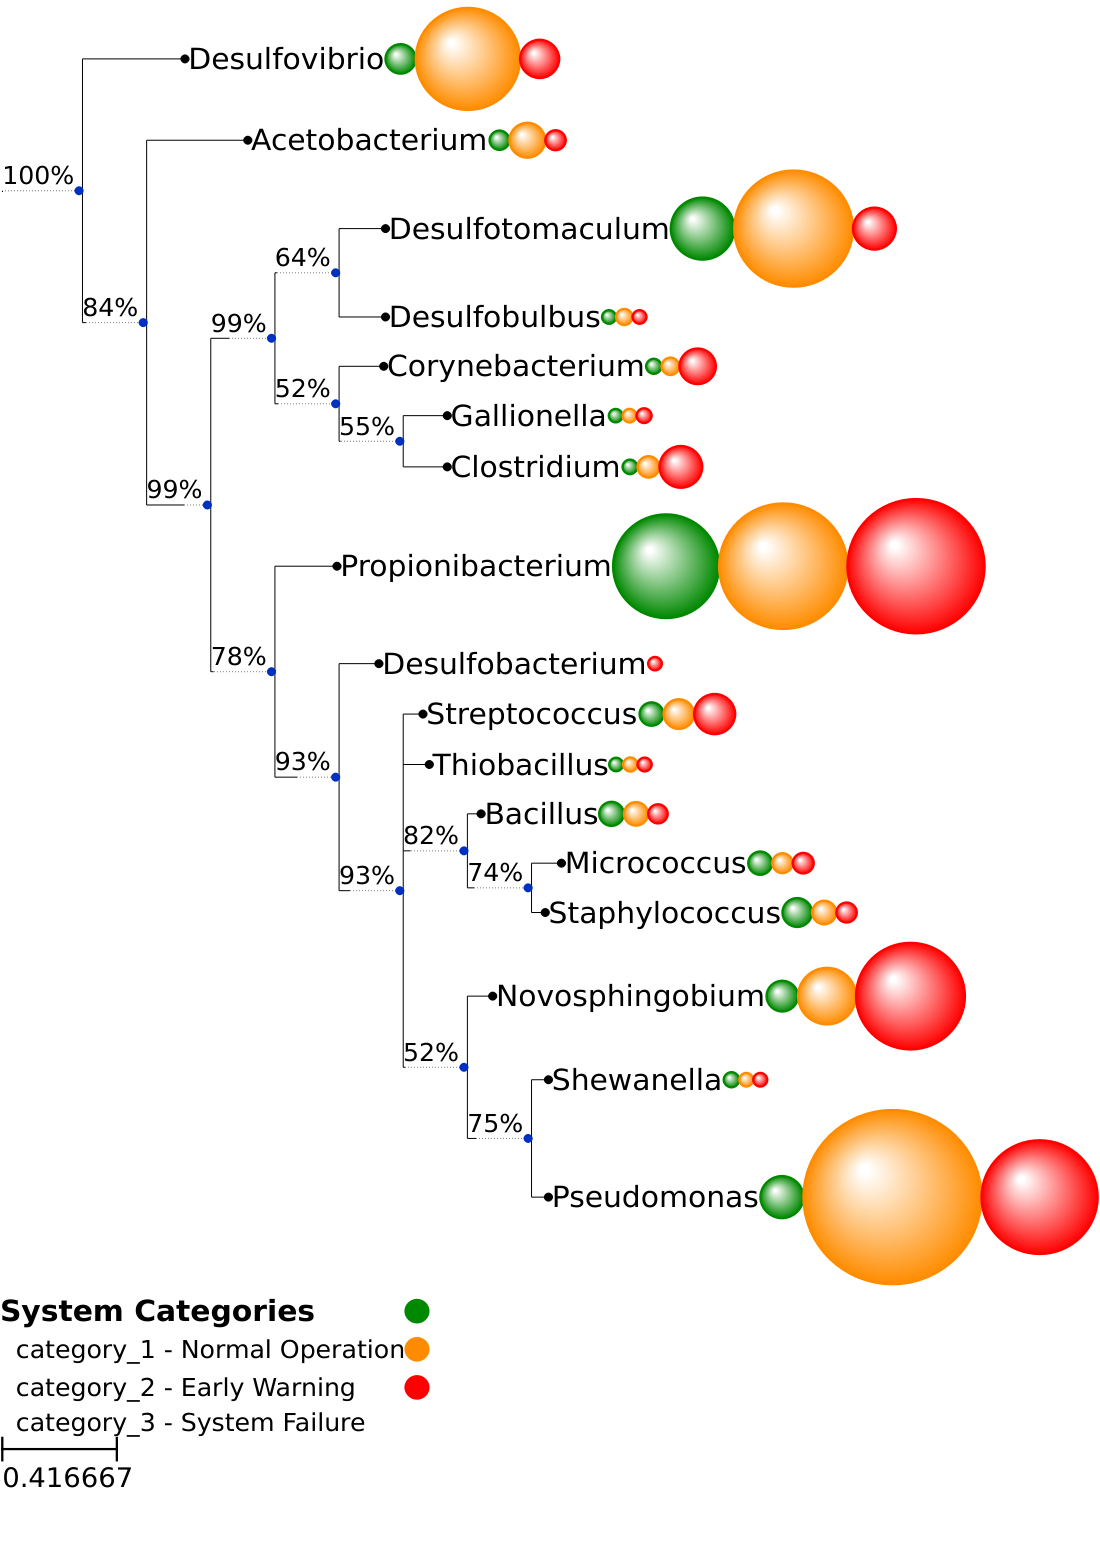 
### Phylogenetic Tree of checked_taxa using MUSCLE

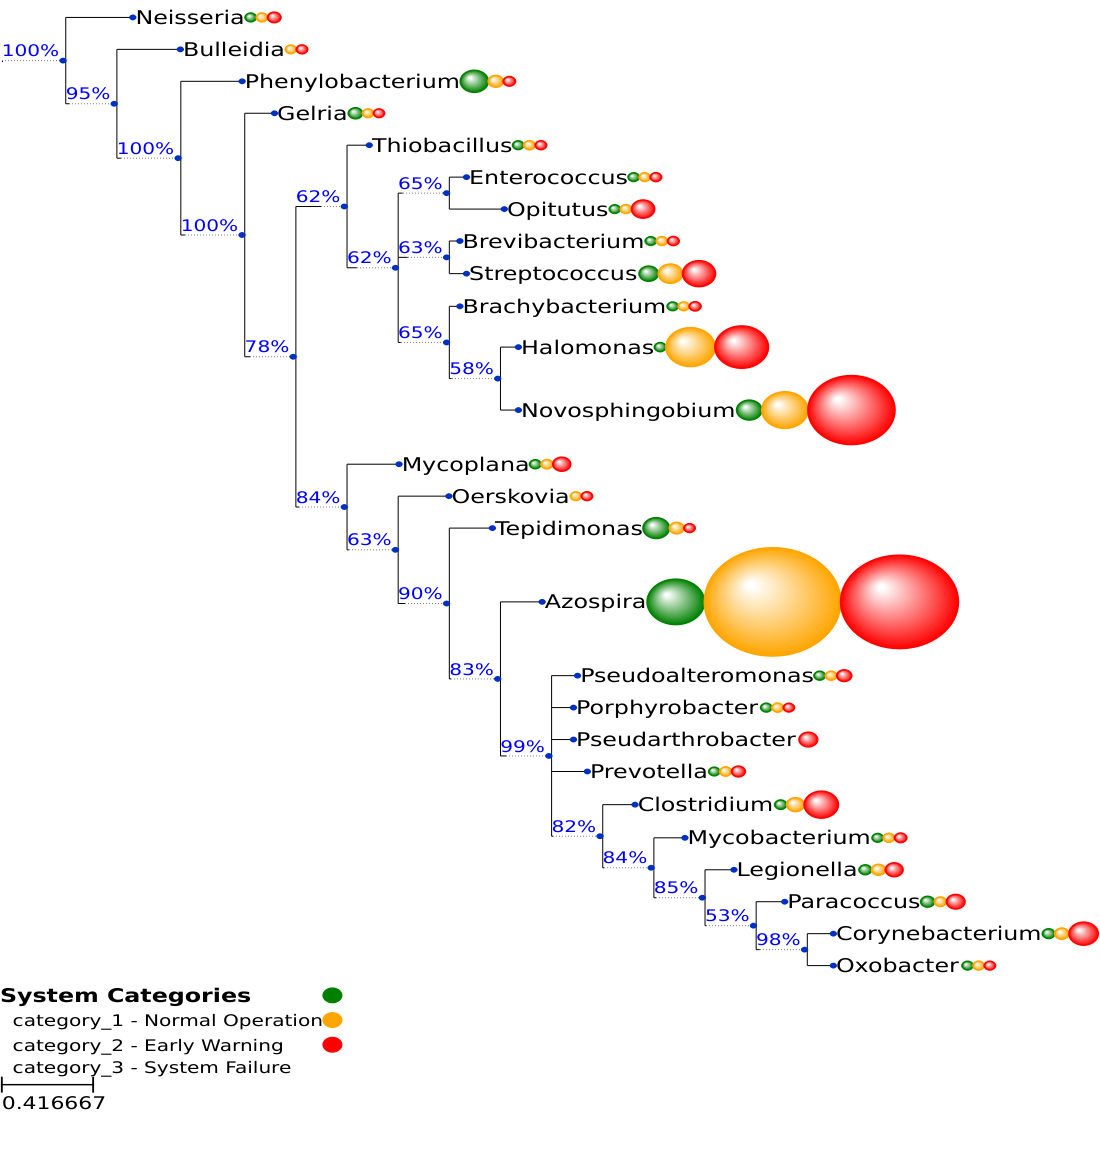

#### Phylogenetic Tree for core_taxa using MUSCLE

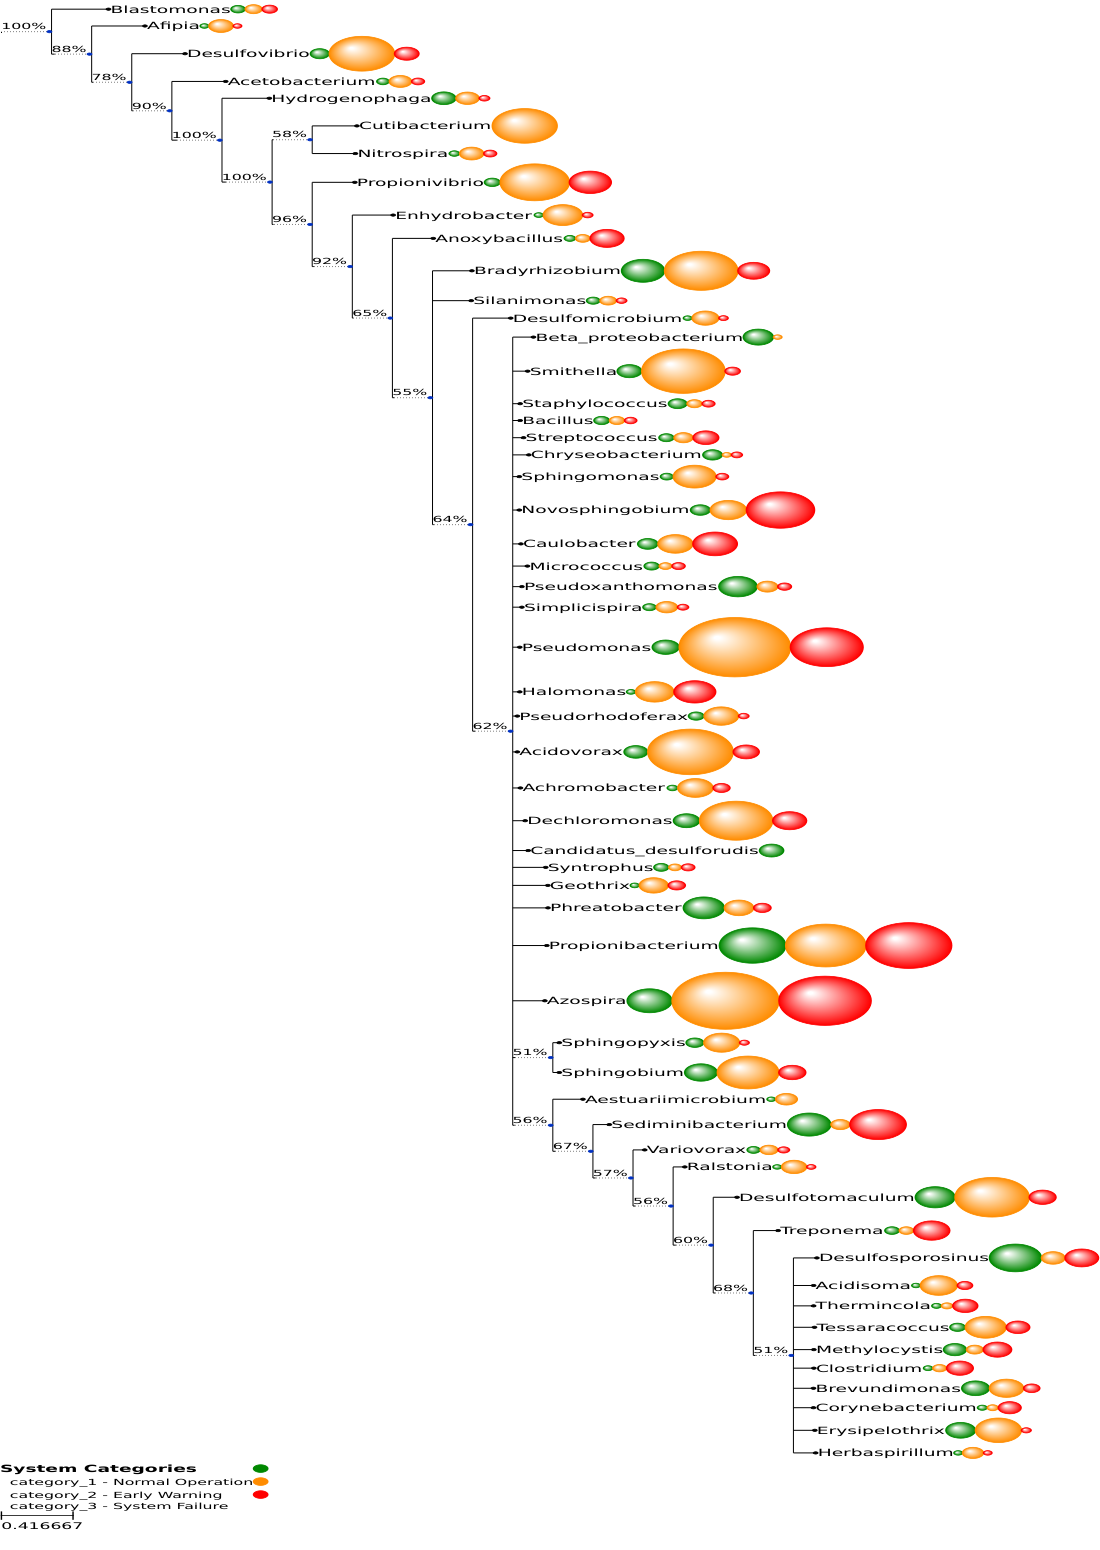

### Phylogenetic Tree for check_core_usual_taxa using MUSCLE
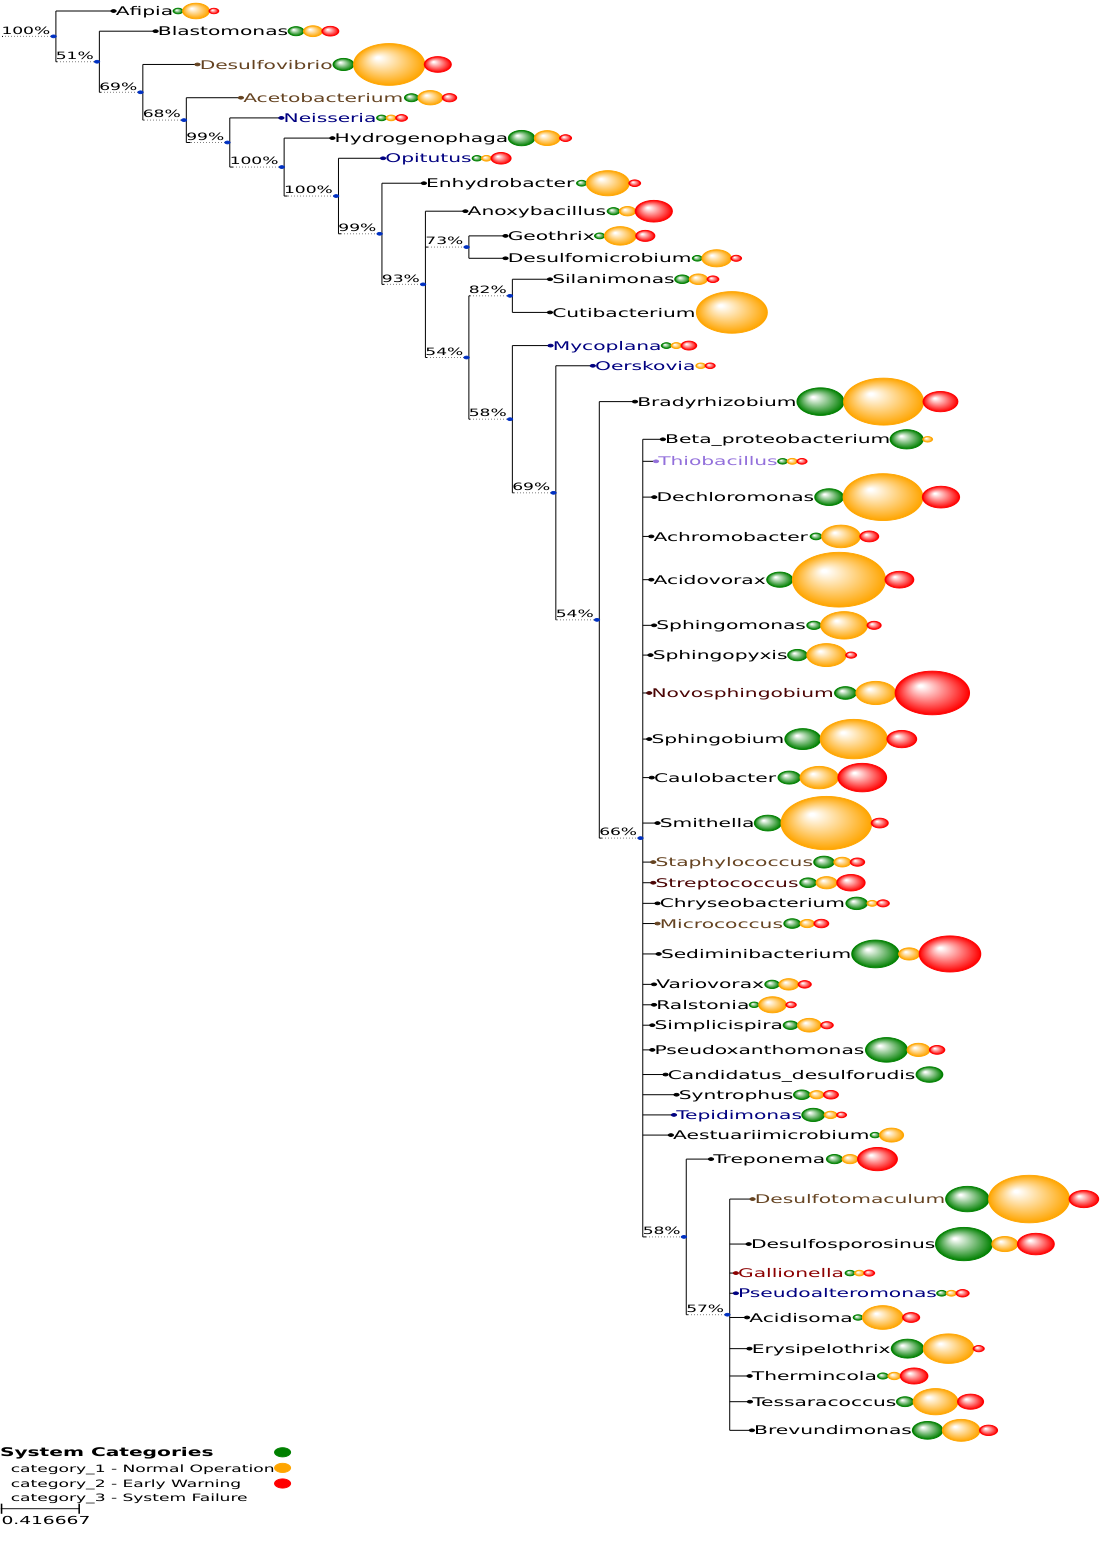
### Phylogenetic Tree for check_core_usual_taxa using QIIME2
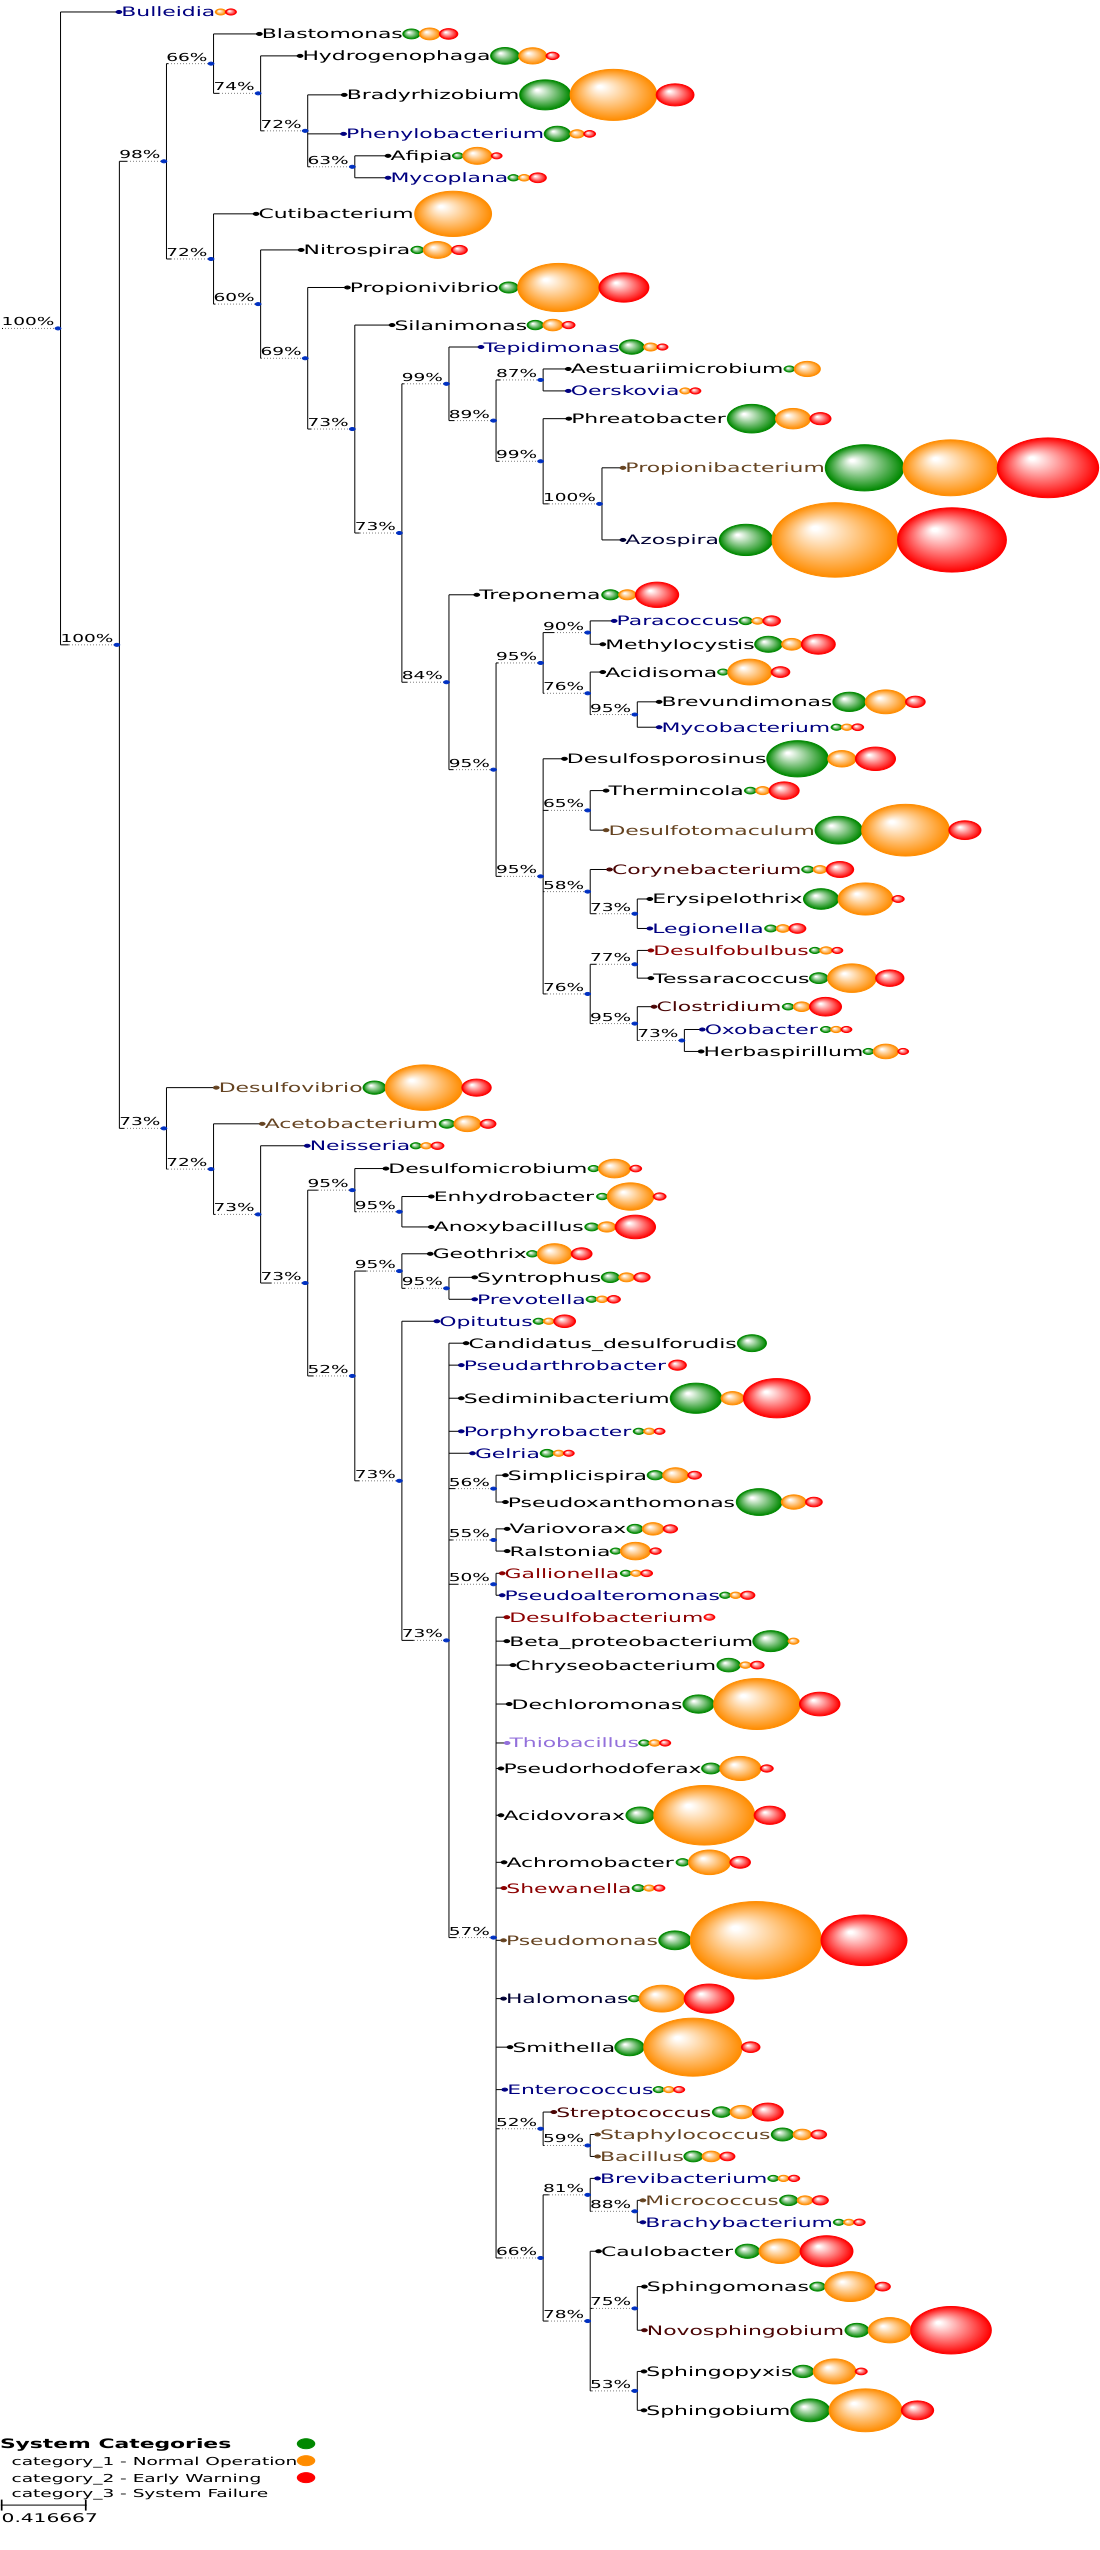


Comparing between the trees made A aligned with Muscle. B made with MAFF alignment through QUIMME2 with agressive masking using DADA . no seeing on this pictures but on the main document. Tree B MAFF alignment only trimming. C made with MAFFT alignment through QIIME2 on trimmed sequences.
All these trees correspond to the integrated data Tree A aligned with MUSCLE show a ladder like structure with less balance evolutionary relationships. 
Tree B Applied aggressive masking parameters where first mask: gap_frequency=0.8, conservation=0.3 and final mask: gap_frequency=0.5, conservation=0.4. It shows an improvement to more balanced hierarchical relationships but too compresed by masking and compared to just the trimming tree C a more ladder-like structure, less balanced evolutionary relationships.Tree C aligned with MAFF only trimming (where only 6 sequences were trimmed to 1700bp but all 79 genera were retained, min_length=500bp, max_length=1700bp) appears to be more balanced amongst the tree, showing more natureal branch lengths, with bootstrap support more balanced 50-100%. Clearer hierarchical clustering, with good resolution for the deeper clades. The abundance patters are more distributed and interpretable.

### Summary of Phylogenetic Analysis for PICRUSt Preparation for MAFF aligned just trimmed consensus tree

The phylogenetic analysis revealed several key patterns that will be important for functional prediction using PICRUSt:

1. **Evolutionary Groups**
- Clustering between traditional corrosion-associated bacteria and newly identified genera. Oxobacteria place itself as a desendent of the Clostridum branch, which suggest shared metabolic capabilities. Oerskovia is an evolutionary ancester of Propionibacterium, which suggest the latest as niche adaptation. Micoplana has no clear relationship and it is a branch where we found phenylobacterium which present an inverse relationship with the risk label and we have propose to be a pioner specie in corrosion systems or have a protective/competitive role on the system. Indeed one of the ancesters Hydrogenophage is presents similar behaviour.  Bulleidia the last of the candidates appears to be very different as all the others finding itself on a completely different branch, which makes it very interesting feature since there is no presence of it on normal systems, this suggest it could be a specialised opportunist.
High bootstrap support (100-73%) for deep branches, indicating reliable evolutionary relationships. The deep branching pattern between aerobin and anaerobic organism suggest multiple independent evolution events of corrosion related traits. This clear metabolic evolution pattern from anaerobic to aerobic organisms, for instance anaerobic organisms such as Desulfovibrio, Desulfobulbus, Desulfotomaculum (sulfate-reducing bacteria), Clostridium (obligate anaerobe),Propionibacterium (facultative anaerobe) to aerobic organisms such as Novosphingobium (strictly aerobic), Legionella (strictly aerobic), Pseudomonas (obligate aerobe), Hydrogenophaga (aerobic), Corynebacterium (aerobic to facultative anaerobic). Desulfovibrio as ancester on its branch, shows a very clear patter of a pioneer species which has dominance as corrosion starts Category 2, but get outcompeted as the systems deteriorate Category 3. 

2. **Functional Patterns**
Sulfate-reducing bacteria (like Desulfovibrio) show pioneer species behavior, declining in category 3 environments. Novosphingobium which functional mechanim is recognised to be strictly aerobic metabolism presents itself as a good marker for these systems since is on high abundance and frequency and has a clear increasing abundance with the risk label. Novosphingobium can breaking down complex organic pollutants, producing extracellular polymeric substances (EPS) which form biofilm, additionally is metal tolerant, bio-transform it. The clustering of Novosphingobium with other high-abundance species suggests co-evolution of traits beneficial in deteriorating systems. Also Legionella as a aerobic-mechanims bacteria show similar patterns as Corynobacterium and are on closer branches, their presence in later stages of corrosion makes sense as oxygen becomes more available due to biofilm development and system deterioration. Biofilm-forming bacteria (Streptococcus, Corynebacterium, Clostridium) cluster together. Novel protective associations discovered (e.g., Phenylobacterium, Hydrogenophaga) potentially due to aromatic compound metabolism outcompeting organometalic transformations? suggesting their protective role might be an ancestral trait.

3. **Community Succession**
Clear ecological succession from early colonizers to late-stage communities is shown and the bootstrap values support the reliability of these succession patterns. Some bacteria appears to have a conflicting pattern being recognised usual corrosive influencing bacteria, however showing bigger presence on category 1 this is the case of Micrococcus, Bacillus, Staphylococcus and Shewanella. The contradictory behavior of known corrosion-influencing bacteria (Micrococcus, Bacillus, etc.) might indicate system-specific roles. Other usual bacteria do no show special pattern on this systems such as Gallionella. Some genera maintain presence across categories but with shifting abundances.Temperature-tolerant and halotolerant bacteria form distinct clusters

4. **Key Findings for PICRUSt**
Mixed clades of known and novel corrosion-associated bacteria suggest shared metabolic capabilities. Also there is evidence of potential shifting meachanisms due to system degradation and a consequent environmental adaptation on the bacteria that has bigger presence on Category 2 right?. The nobel candidates show strong bootstrap support, which validates their inclusion in functional analysis.

This phylogenetic foundation suggests that PICRUSt analysis should focus on- Metabolic pathways shared between traditional and newly identified corrosion-associated bacteria. Veryfy the assumptions of the analysis, get deeper understanding of functional transitions between succession stages
Compare metabolic potential between pioneer species and late-stage colonizers. Understand the protective metabolic capabilities in inverse-relationship genera by analysing shared pathways between for instance Phenylobacterium-Hydrogenophaga clade members. Maybe will be good idea to trimm out the usual genera that  behave on a contradictory way? : Micrococcus, Bacillus, Staphylococcus and Shewanella. Or focus on comparing metabolic pathways between contradictory behavior species and consistent behavior species. Investigate metabolic capabilities of the unique Bulleidia branch

In [468]:
from ete3 import Tree, TextFace

# Load the tree
t = Tree("data/consensus_tree.newick", format=0) 

# Metabolic data 
metabolic_data = {
          'Clostridium': 'Pathway_Z',
      'Corynebacterium': 'Pathway_A',
               'Gelria': 'Pathway_B',
          'Haemophilus': 'Pathway_C',
            'Halomonas': 'Pathway_D',
           'Legionella': 'Pathway_E',
            'Oerskovia': 'Pathway_F',
            'Oxobacter': 'Pathway_G',
        'Porphyromonas': 'Pathway_H',
              'Psb-m-3': 'Pathway_I',
    'Pseudarthrobacter': 'Pathway_J',
    'Pseudoalteromonas': 'Pathway_K',
          'Rhodobacter': 'Pathway_L',
           'Roseateles': 'Pathway_M',
            'Roseococc': 'Pathway_N'
}

# Annotate the tree
for leaf in t.iter_leaves():
    if leaf.name in metabolic_data:
        metabolic_info = TextFace(metabolic_data[leaf.name])
        leaf.add_face(metabolic_info, column=1, position="branch-right")

# Show or render the tree
t.show()
# Render the tree
#t.render("%%inline", w=800, units="px", tree_style=ts)

NewickError: Unexisting tree file or Malformed newick tree structure.
You may want to check other newick loading flags like 'format' or 'quoted_node_names'.

## 6.6. Missing Bacteria
Different searchs have been unsuscessfull retrieving the total of the bacteria sequences, with a failing percentage of 50-95%. In the last search there were some missing bacteria, therefore the idea is to append them to the accension_taxa dataframe so that we can plot the missings ones.

In [ ]:
# 1. First load the dataframes and verify they loaded correctly
all_taxa = pd.read_excel('~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx',
                        sheet_name='core_check_usual_taxa',
                        header=[0,1,2,3,4,5,6,7])
print("all_taxa loaded:", type(all_taxa))

accession = pd.read_csv('data_tree/taxa_accension.csv')
print("accession loaded:", type(accession))

# 2. Check the structure of each dataframe
print("\nall_taxa columns:")
print(all_taxa.columns.get_level_values(6))

print("\naccession columns:")
print(accession.columns.tolist())

# 3. Now try the comparison
all_taxa_g = set(all_taxa.columns.get_level_values(6))
accession_g = set(accession['Genus'])  # Make sure 'Genus' is actually a column name
missing_genera = all_taxa_g - accession_g

print("\nMissing genera:")
for genus in sorted(missing_genera):
    print(f"- {genus}")

Missing genera:
- Clostridium_sensu_stricto_12
- Oxalobacteraceae_unclassified
- Psb-m-3
- Ruminiclostridium_1
- Unnamed: 0_level_6
- Unnamed: 1_level_6
- Unnamed: 2_level_6
- Wchb1-05

In [40]:
# Comunicating with the NCBI
from config import NCBI_API_KEY, NCBI_EMAIL

Entrez.email= "wattsbeatrizamanda@gmail.com" #
Entrez.api_key  = "01d2f369faef0e78cd4906063672fab7c809"


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)


In [41]:
def search_sequences(genus, entrez, max_retries=5, base_delay=30, max_delay=120):
    """
    Search for sequences with improved error handling and validation.
    """
    if not isinstance(genus, str) or not genus.strip():
        raise ValueError("Genus must be a non-empty string")
    if not hasattr(entrez, 'email') or not entrez.email:
        raise RuntimeError("Entrez email configuration missing")
    
    retry_count = 0
    delay = base_delay

    while retry_count < max_retries:
        try:
            search_term = (f"{genus}[Organism] AND "
                         "(16S[All Fields] OR 16S ribosomal RNA[All Fields] OR "
                         "16S rRNA[All Fields]) AND "
                         "500:2000[Sequence Length]")
            
            logging.info(f"Attempting search for {genus} (attempt {retry_count + 1}/{max_retries})")
            # Search NCBI database
            handle = entrez.esearch(db="nucleotide", term=search_term, retmax=100)
            
            try:
                record = entrez.read(handle)
                time.sleep(5)
            except entrez.Parser.ValidationError as ve:
                logging.error(f"NCBI validation error for {genus}: {str(ve)}")
                retry_count += 1
                continue
            finally:
                handle.close()
            
            sequence_count = len(record.get('IdList', []))
            logging.info(f"Found {sequence_count} sequences for {genus}")
            
            if sequence_count > 0:
                return record['IdList']
            
            logging.warning(f"No sequences found for {genus}")
            return []
            
        except Exception as e:
            logging.error(f"Error in search for {genus}: {str(e)}")
            
        retry_count += 1
        if retry_count < max_retries:
            wait_time = min(delay * (2 ** retry_count), max_delay)
            logging.info(f"Waiting {wait_time} seconds before retry...")
            time.sleep(wait_time)
    
    return []

In [42]:
def append_missing_genera():
    
    # Read existing results
    existing_df = pd.read_csv('data_tree/taxa_accension.csv')
    
    # Search only for missing bacteria
    additional_results = {}
    for bacteria in missing_genera:
        print(f"Searching for {bacteria}...")
        result = search_sequences(bacteria, Entrez)
        if result:
            additional_results[bacteria] = result
            print(f"Found sequences for {bacteria}")
        else:
            print(f"No sequences found for {bacteria}")
        time.sleep(30)  # Being nice to NCBI
            
    # Create DataFrame for new sequences
    new_sequences = pd.DataFrame(list(additional_results.items()), 
                               columns=['Genus', 'IDs'])
    
    # Save new sequences separately
    new_sequences.to_csv('data_tree/additional_sequences.csv')
    
    # Combine for further processing
    combined_df = pd.concat([existing_df, new_sequences], ignore_index=True)
    combined_df.to_csv('data_tree/combined_taxa_accension.csv')
    
    return combined_df

In [ ]:
# Search just the missing genera
missing_genera = [
    "Clostridium_sensu_stricto_12",
    "Oxalobacteraceae_unclassified",
    "Psb-m-3", 
    "Ruminiclostridium", #_1
    "Wchb1-05"
]
results_missing = {}
for bacteria in missing_genera:
    print(f"Searching for {bacteria}...")
    result = search_sequences(bacteria, Entrez)  # Keep this as result
    if result:
        results_missing[bacteria] = result    # Store in results_missing
        print(f"Found sequences for {bacteria}")
    time.sleep(30)  # Being nice to NCBI

In [ ]:
# Create DataFrame for new sequences
new_sequences = pd.DataFrame(list(results_missing.items()), columns=['Genus', 'IDs'])

# Read existing file
existing_df = pd.read_csv('data_tree/taxa_accension.csv')

# Combine old and new
combined_df = pd.concat([existing_df, new_sequences], ignore_index=True)

# Save with new name to be safe
combined_df.to_csv('data_tree/taxa_accension_complete.csv', index=False)